### Imports

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy.stats as stats
from sklearn.metrics import pairwise_distances, silhouette_score, davies_bouldin_score

# 1. Prepare Time Series Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 76)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,851.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1553.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,18.0,28.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [3]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [4]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [5]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [6]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [7]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [8]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [9]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [10]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

208

In [11]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.15

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 713


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,486.0,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-8.660254e-01,69
2,1039.0,2016.0,DETROIT,42.4190,-83.0393,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,8.660254e-01,148
3,1018.0,2016.0,WASHINGTON,38.9030,-76.9820,18.0,28.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,145
4,529.0,2015.0,PITTSBURGH,40.4621,-80.0308,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000e+00,75
7,805.0,2016.0,NEWHAVEN,41.2945,-72.9457,24.0,24.0,24.0,1.0,0.0,...,False,False,False,False,False,False,False,1.000000e+00,6.123234e-17,115


In [12]:
# Save dataset in csv
dataset.to_csv('debugging/ts.csv', index=False)

## 1.3 Generation with different score functions for each subtask

In [13]:
from tslearn.preprocessing import (TimeSeriesScalerMeanVariance,
                                   TimeSeriesScalerMinMax)

Define the functions to compute the score for each of the two subtasks. The score used is the <b><u> perceived risk </b></u> computed in an "eligibility trace fashion", borrowing this concept from reinforcement learning rewards. We add to the score the number of incidents in the current week, and we sum the score of previous weeks, decaying it by multiplying it by a factor alpha.

In [14]:
# Define the threshold for the number of killed people in a city 
# to be considered as a label 1 class
ISKILLED_THRESHOLD = 25

def compute_week_score(week_data, task, prev_score, alpha = 0.5):
    """Compute the score for a given week, to be used in the time seriesw

    Args:
        week_data (pandas.DataFrame): Data for a given week
        task (str): Task to be performed, used for deciding score function.
        prev_score (float): Score of the previous week
        alpha (float, optional): Weight for the previous score. Defaults to 0.5.

    Returns:
        float: Score for the given week
    """
    if task == 'clustering' or task == 'shapelet_learning' or task == None:
        score = prev_score * alpha + week_data.shape[0]
    return score


def generate_time_series_with_label(city_data, n_weeks, task):
    """Generate the time series for a given city.
    Label is referred to the whole time series.

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed, used for deciding score function.

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, )
        int: Label for the time series
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task, time_series[week - 1])
    
    if (city_data['killed_ratio'] * city_data['n_participants']).sum() > ISKILLED_THRESHOLD:
        label = 1
    else:
        label = 0

    return time_series, label

def generate_time_series_dataset(dataset, task = None):
    """Generate the time series dataset

    Args:
        dataset (pandas.DataFrame): Dataset
        task (str, optional): Task to be performed, used for deciding score function. Defaults to None.

    Returns:    
        list: [Time series dataset, labels]
        numpy.ndarray: Cities of the time series dataset
    """
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city_or_county'].unique()
    time_series = []
    labels = []
    for city in cities:
        city_data = dataset[dataset['city_or_county'] == city]
        ts, label = generate_time_series_with_label(city_data, n_weeks, task)
        time_series.append(ts)
        labels.append(label)
        
    time_series = np.array(time_series)
    labels = np.array(labels)
    
    time_series = [time_series, labels]

    return time_series, cities

In [15]:
class TSScaler:
    """Base class to scale time series data
    """
    def __init__(self, verbose = True):
        self.verbose = verbose

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    
    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    

class MinMaxScaler(TSScaler):
    """Class to scale time series data using minmax scaling
    """
    def __init__(self, verbose = True):
        super().__init__(verbose)
        self.min = None
        self.max = None

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        self.min = time_series.min(axis = 1).min(axis = 0)
        self.max = time_series.max(axis = 1).max(axis = 0)
        return self.transform(time_series)

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Scaling time series with MinMaxScaler')
        return (time_series - self.min) / (self.max - self.min)

    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Inverse scaling time series with MinMaxScaler')
        return time_series * (self.max - self.min) + self.min

In our case, no resampling is necessary as all sequences are of same length, as we define them over 208 weeks. Furthermore, no approximation is needed as the resulting dataset of time series is small.

<b>Important!!!</b> Keep in mind that minmax scaler in tslearn scales each time series independently, so the two following time series of killed people in our dataset will look identical:

1. 0 - 0 - 100 - 0 - ... - 0
2. 0 - 0 -  1  - 0 - ... - 0

This is because usually one would like to do amplitude scaling on the dataset (e.g. if the signal is electrical tension, and the important thing is the shape of the signal and not the amplitude itself). However, in our case it is important to consider this loss in information. For this reason, we implement our own minmax scaler.

## 1.4 Generate time series dataset

In [16]:
ts_dataset, cities = generate_time_series_dataset(dataset)
X = ts_dataset[0]
y = ts_dataset[1]
print('Shape of X:', X.shape)   
print('Shape of y:', y.shape)

Shape of X: (713, 208)
Shape of y: (713,)


In [17]:
scaler_minmax = MinMaxScaler()
scaler_zscore = TimeSeriesScalerMeanVariance()  
scaler_minmax_independent = TimeSeriesScalerMinMax()

X_minmax = scaler_minmax.fit_transform(X)
X_zscore = scaler_zscore.fit_transform(X)
X_minmax_independent = scaler_minmax_independent.fit_transform(X)

print('Minmax scaled dataset shape:', X_minmax.shape)
print('Zscore scaled dataset shape:', X_zscore.shape)
print('Minmax independent scaled dataset shape:', X_minmax_independent.shape)
print()
print('Shapes of minmax scaled dataset modified for compatibility with tslearn:')
X_minmax = np.expand_dims(X_minmax, axis=2)
print('Minmax scaled dataset shape:', X_minmax.shape)



Scaling time series with MinMaxScaler
Minmax scaled dataset shape: (713, 208)
Zscore scaled dataset shape: (713, 208, 1)
Minmax independent scaled dataset shape: (713, 208, 1)

Shapes of minmax scaled dataset modified for compatibility with tslearn:
Minmax scaled dataset shape: (713, 208, 1)


We'll use the minmax scaled dataset as we defined it with our class.

In [18]:
scaler = scaler_minmax
X = X_minmax

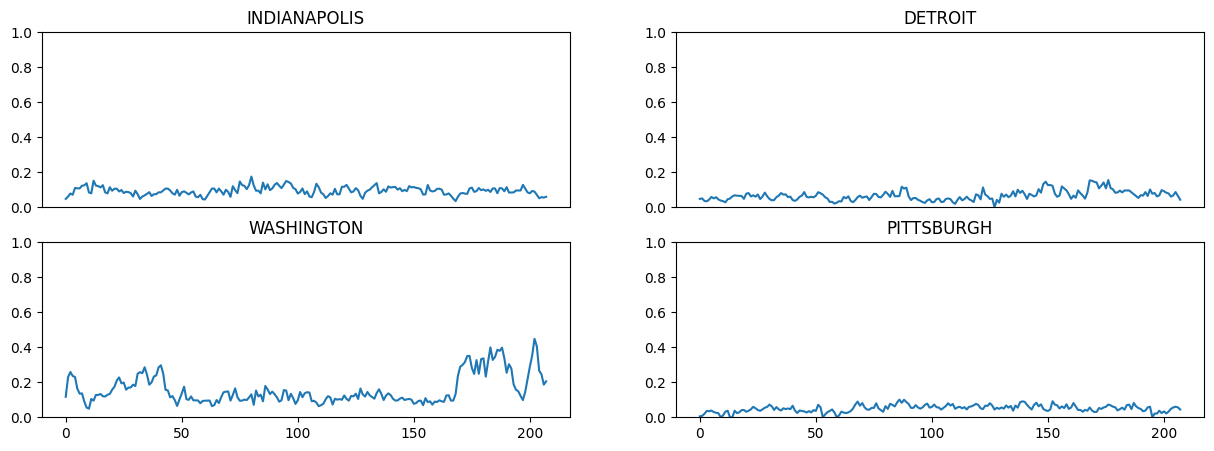

In [19]:
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(X[i])
    plt.ylim(0, 1)
    if i < 2:
        plt.xticks([])
    plt.title(cities[i])
plt.show()

# 2. Clustering

## 2.1 Shape-based Clustering 

In [20]:
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.clustering import silhouette_score as ts_silhouette_score

### 2.1.1 KMeans with Euclidean Distance

In [21]:
max_k = 20

sse_list_km = []
silhouette_list_km = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100, random_state=0, n_init=10)
    km.fit(X)

    if km._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km.append(km.inertia_)
    silhouette_list_km.append(ts_silhouette_score(X, km.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 3.808 s
Finished clustering for k = 3; time elapsed: 4.824 s
Finished clustering for k = 4; time elapsed: 5.473 s
Finished clustering for k = 5; time elapsed: 5.611 s
Finished clustering for k = 6; time elapsed: 5.043 s
Finished clustering for k = 7; time elapsed: 5.331 s
Finished clustering for k = 8; time elapsed: 6.552 s
Finished clustering for k = 9; time elapsed: 4.545 s
Finished clustering for k = 10; time elapsed: 4.607 s
Finished clustering for k = 11; time elapsed: 4.255 s
Finished clustering for k = 12; time elapsed: 6.615 s
Finished clustering for k = 13; time elapsed: 5.464 s
Finished clustering for k = 14; time elapsed: 4.933 s
Finished clustering for k = 15; time elapsed: 5.056 s
Finished clustering for k = 16; time elapsed: 6.227 s
Finished clustering for k = 17; time elapsed: 6.594 s
Finished clustering for k = 18; time elapsed: 5.610 s
Finished clustering for k = 19; time elapsed: 5.796 s
Finished clustering for k = 20; time

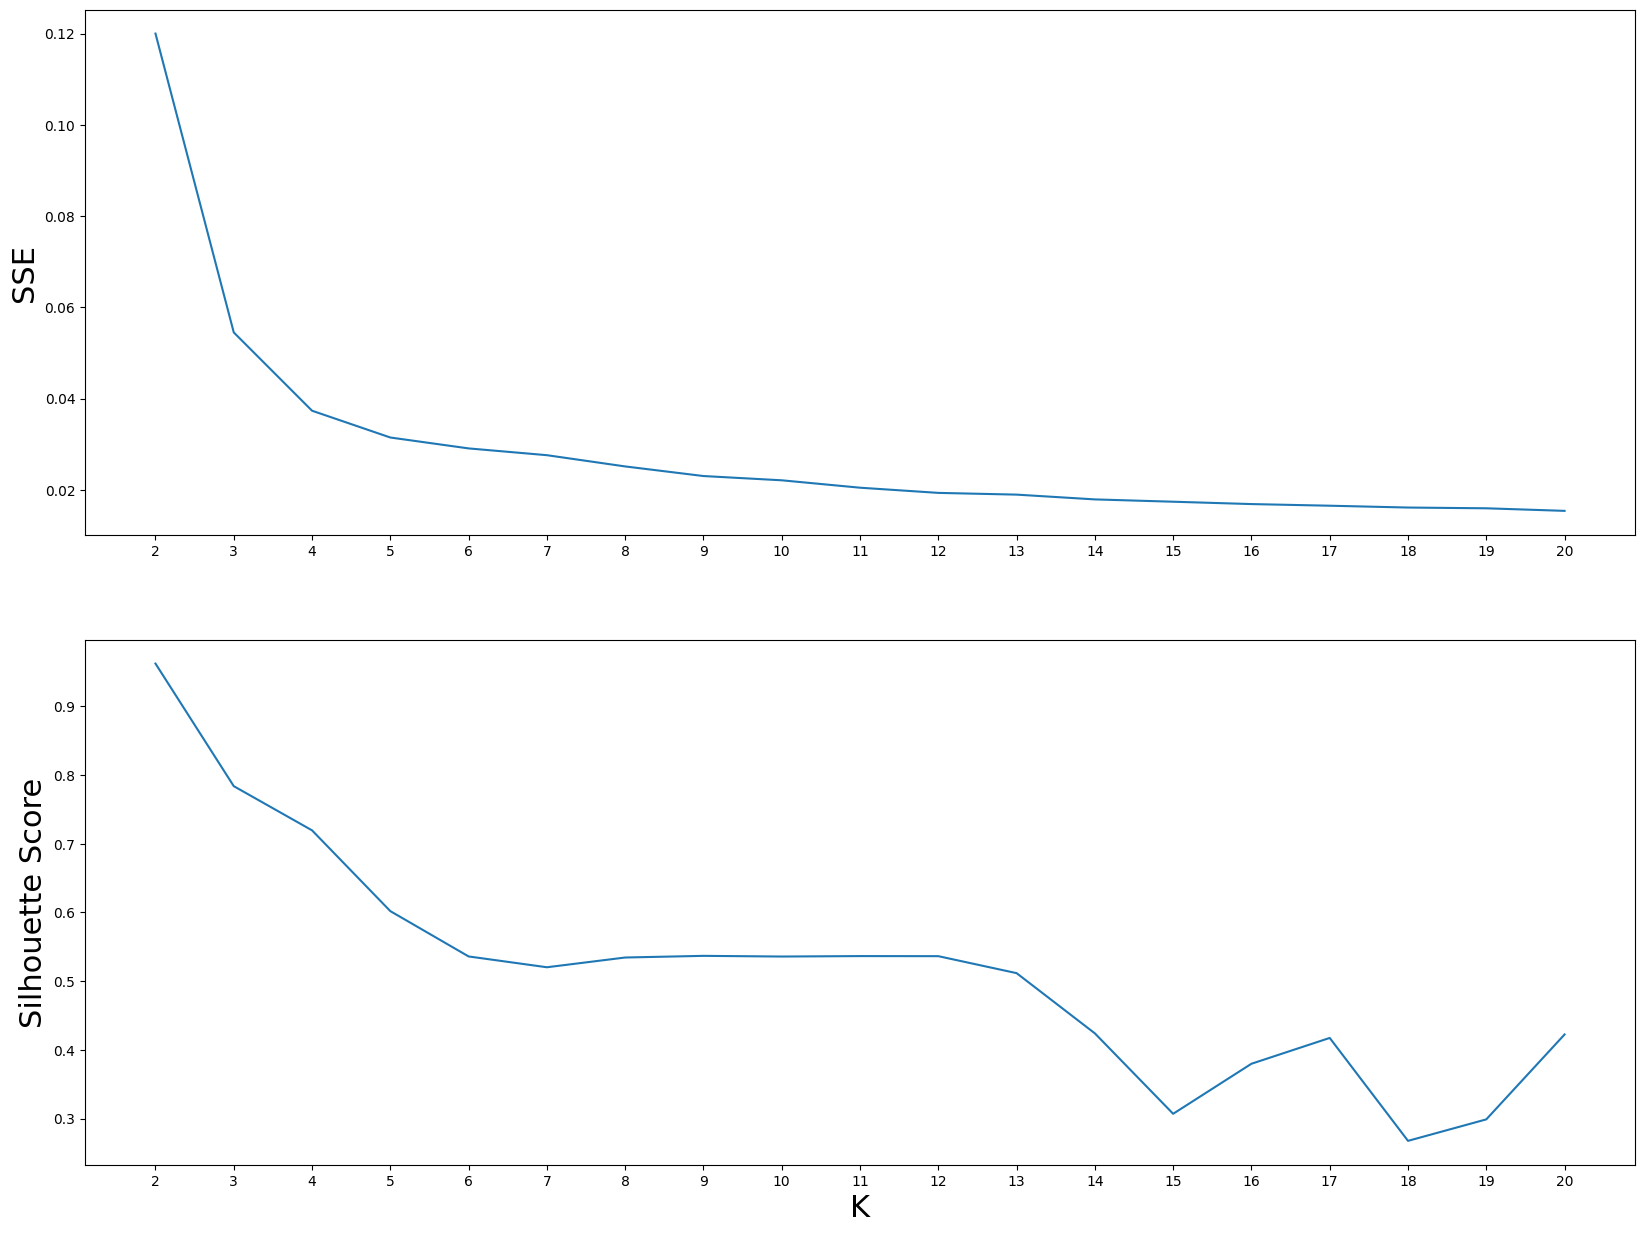

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2),silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))


plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [134]:
CHOSEN_K = 4

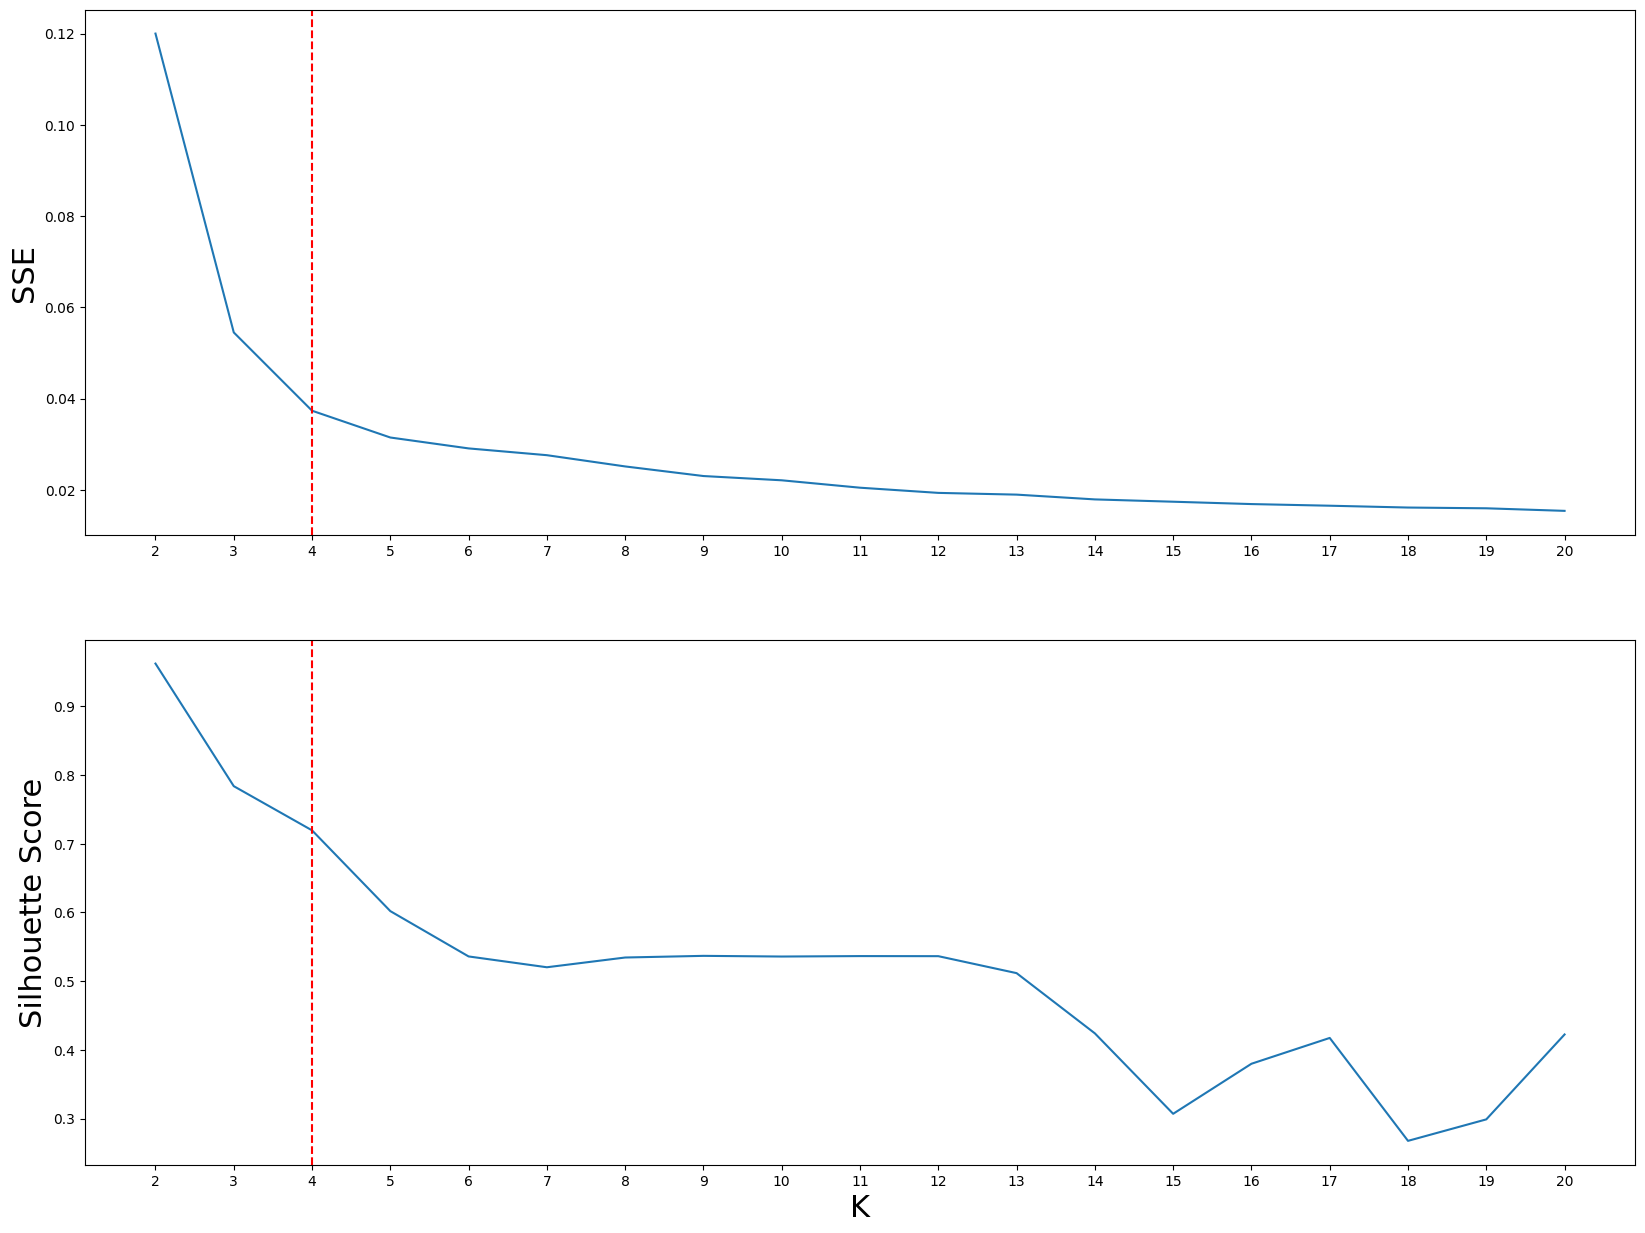

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2), silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [136]:
n_clusters = CHOSEN_K
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=1000, random_state=0, n_init=10)
km.fit(X)

TimeSeriesKMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=0)

In [137]:
km_centers = scaler.inverse_transform(km.cluster_centers_)

Inverse scaling time series with MinMaxScaler


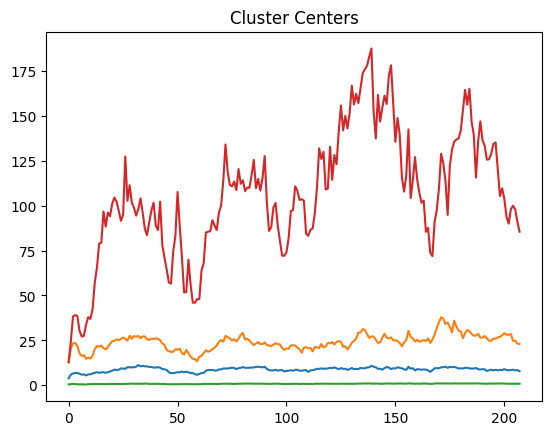

In [138]:
plt.plot(km_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

### 2.1.2 KMeans with DTW

DTW metric requires long computations, as it has complexity asymptotically different from Euclidean distance. Let's explore how much the cost rises.

In [28]:
n_clusters = 3

In [29]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))


Time elapsed for DTW clustering: 348.069 s
Time elapsed for DTW silhouette score: 69.593 s
Number of iterations during training: 13
Total time elapsed for DTW clustering and silhouette score: 417.662 s


This algorithm is much slower than the Euclidean metric version. This is to be expected, as computing Euclidean distance is linear complexity in time, whilst DTW isn't.
 
<b>Let's try with some constraints on DTW!</b>

In [30]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

Time elapsed for constrained DTW clustering: 194.271 s
Time elapsed for DTW silhouette score: 65.302 s
Number of iterations during training: 12
Total time elapsed for DTW clustering and silhouette score: 259.573 s


We notice that even though constraining dtw helps a lot, aanother expensive part is calculating the silhouette score with dtw. So let's use euclidean distance as a metric in silhouette score even when using dtw for clustering. It is still a valid choice for evaluating the clustering.

In [31]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="euclidean")
print("Time elapsed for Euclidean silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

Time elapsed for constrained DTW clustering: 190.827 s
Time elapsed for Euclidean silhouette score: 0.095 s
Number of iterations during training: 12
Total time elapsed for DTW clustering and silhouette score: 190.921 s


Now that we have brought down the time complexity, let's actually run the search for k. Keep max_k = 10 to avoid computing for too long.

In [32]:
max_k = 10 

sse_list_km_dtw = []
silhouette_list_km_dtw = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
    km_dtw.fit(X)

    if km_dtw._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_dtw.append(km_dtw.inertia_)        
    silhouette_list_km_dtw.append(ts_silhouette_score(X, km_dtw.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 165.700 s
Finished clustering for k = 3; time elapsed: 192.225 s
Finished clustering for k = 4; time elapsed: 189.863 s
Finished clustering for k = 5; time elapsed: 199.268 s
Finished clustering for k = 6; time elapsed: 219.587 s
Finished clustering for k = 7; time elapsed: 258.313 s
Finished clustering for k = 8; time elapsed: 251.150 s
Finished clustering for k = 9; time elapsed: 272.971 s
Finished clustering for k = 10; time elapsed: 261.734 s


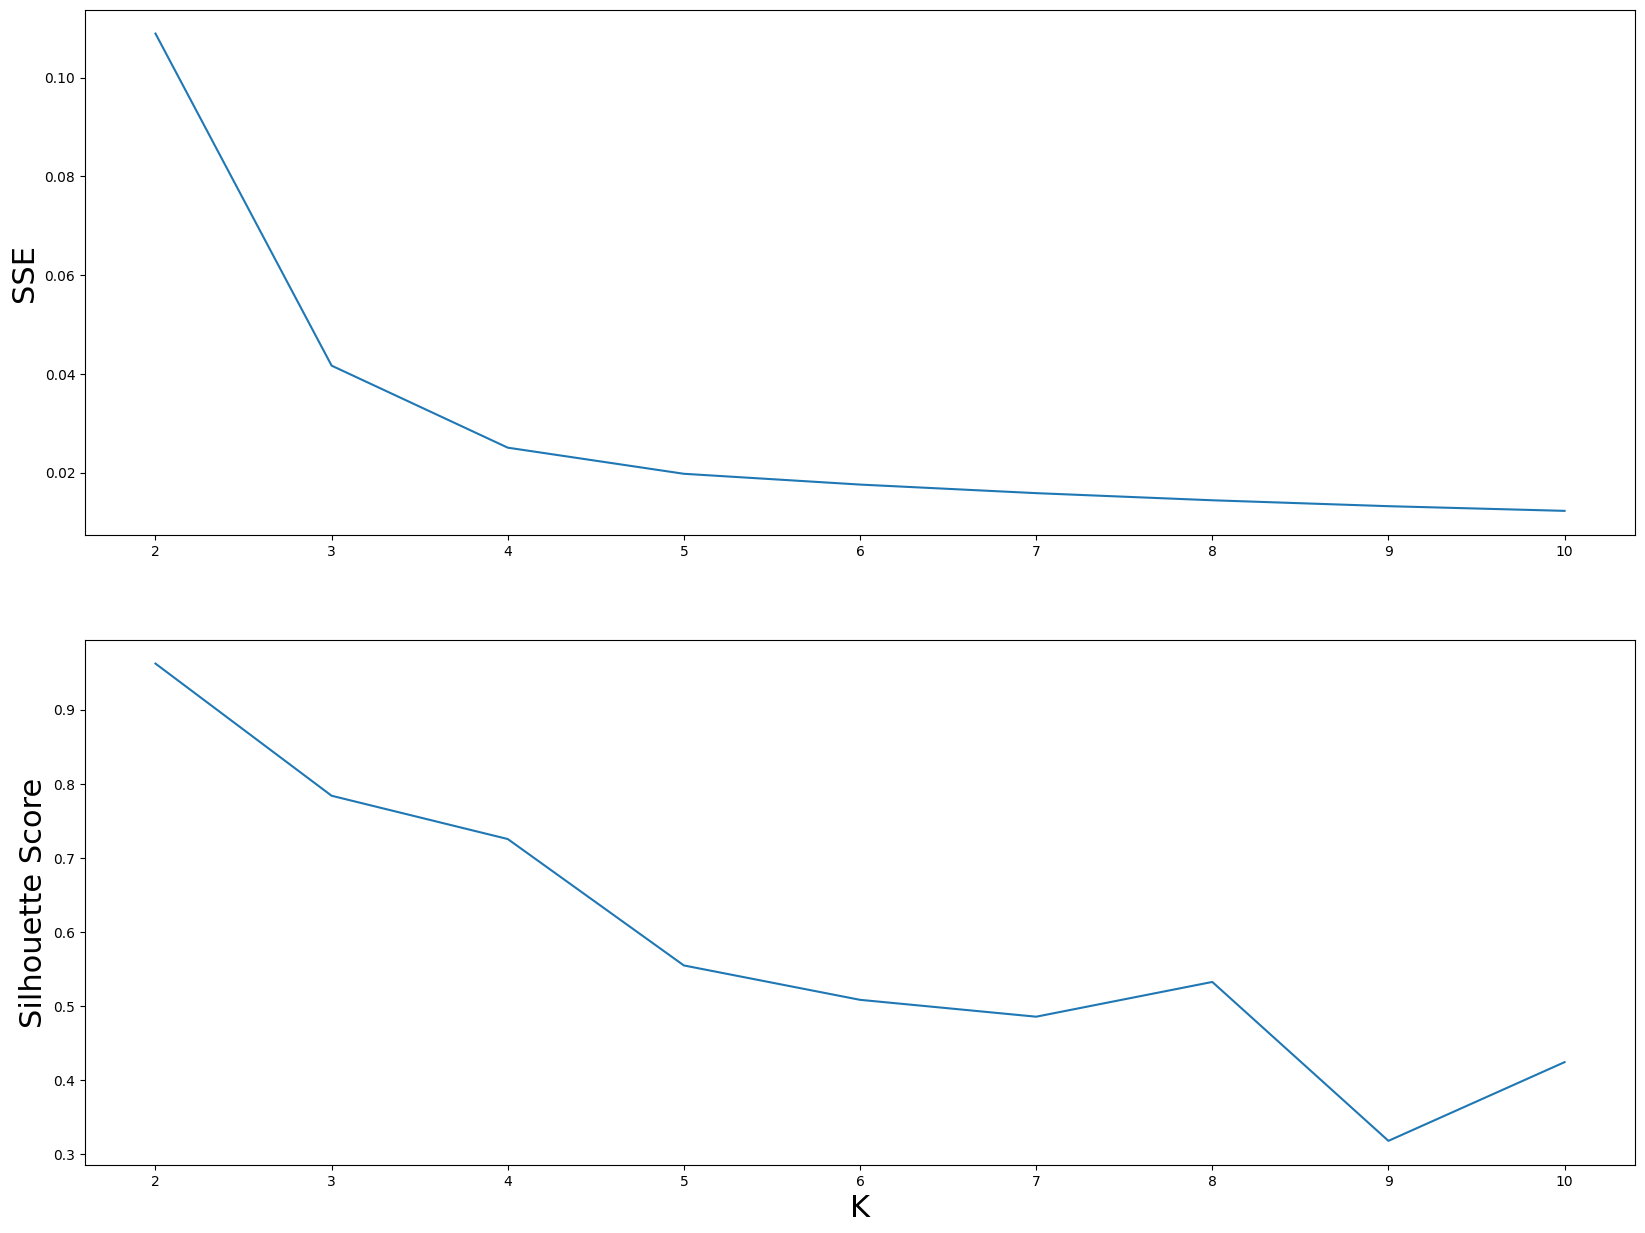

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [173]:
CHOSEN_K = 4

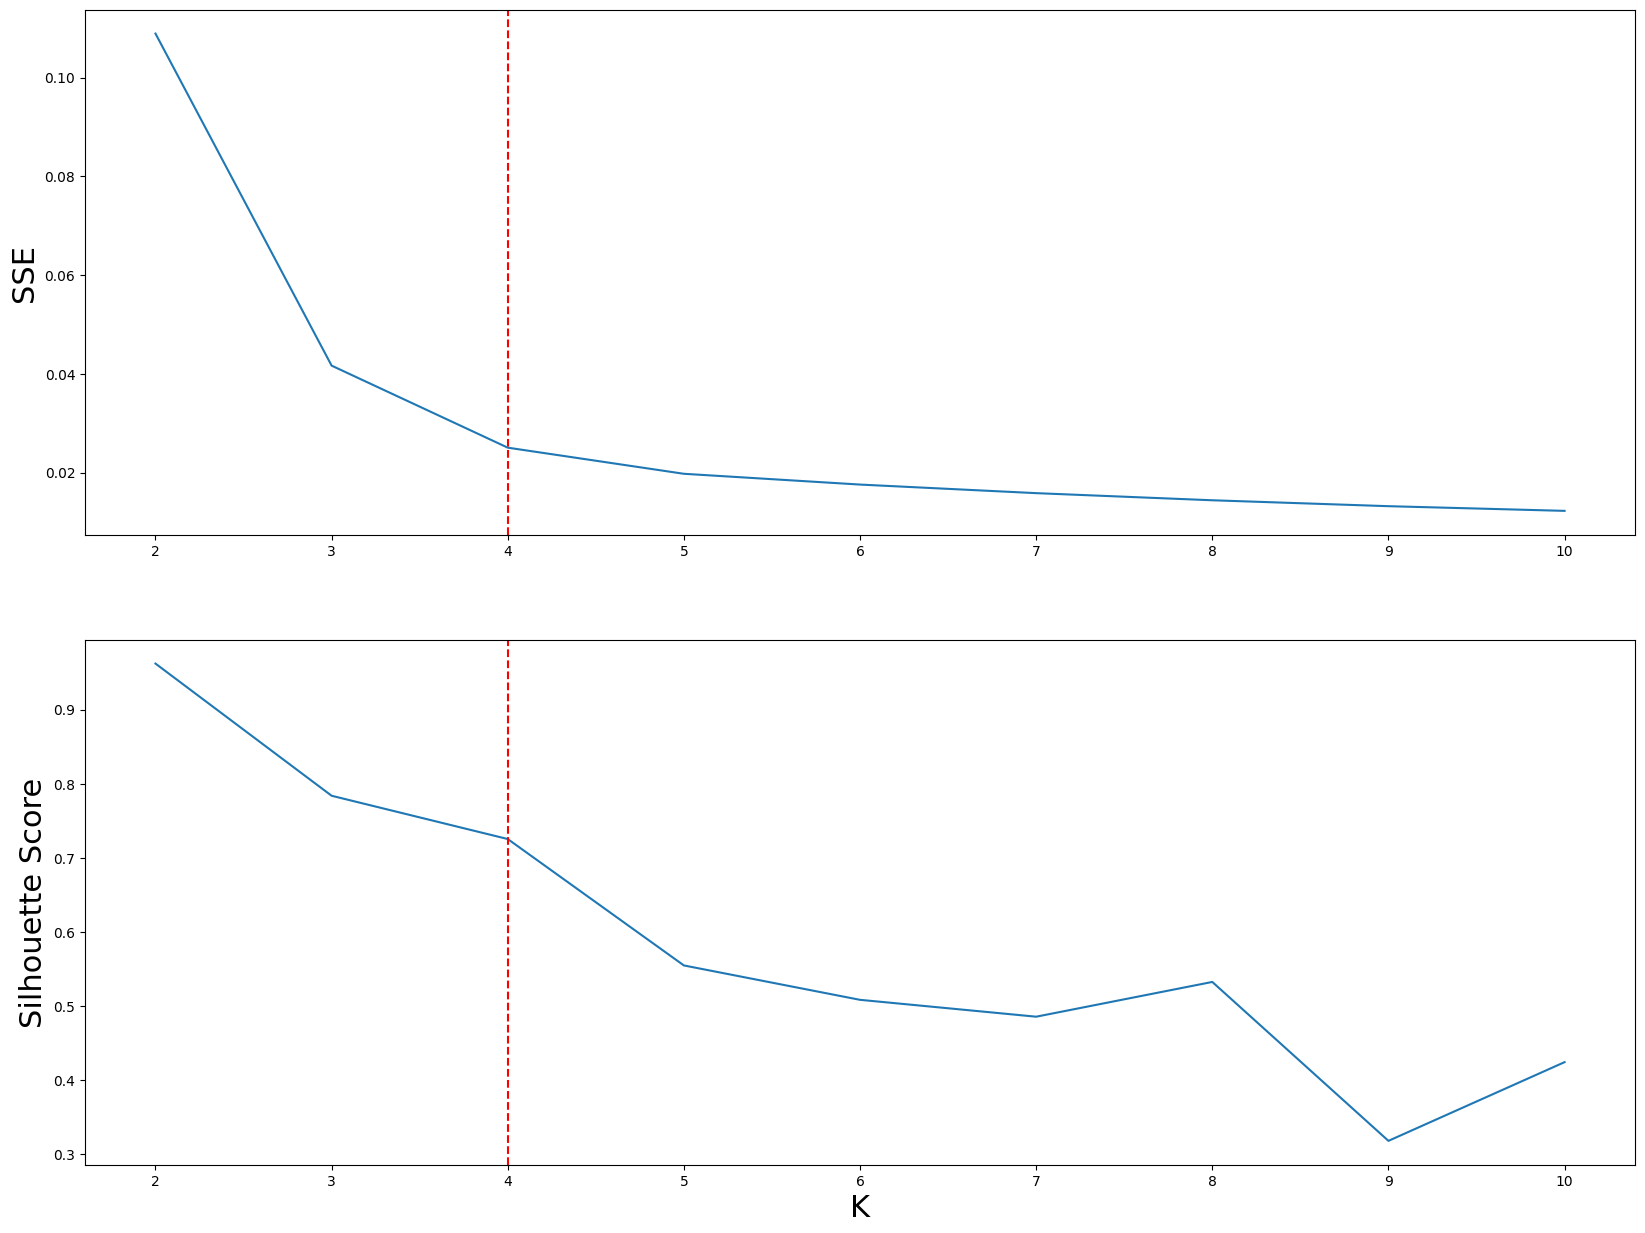

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [175]:
n_clusters = CHOSEN_K
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=100, metric='dtw',
                 metric_params={'global_constraint': 'sakoe_chiba',
                                'sakoe_chiba_radius': 3},
                 n_clusters=4, n_init=10, random_state=0)

In [176]:
km_dtw_centers = scaler.inverse_transform(km_dtw.cluster_centers_)

Inverse scaling time series with MinMaxScaler


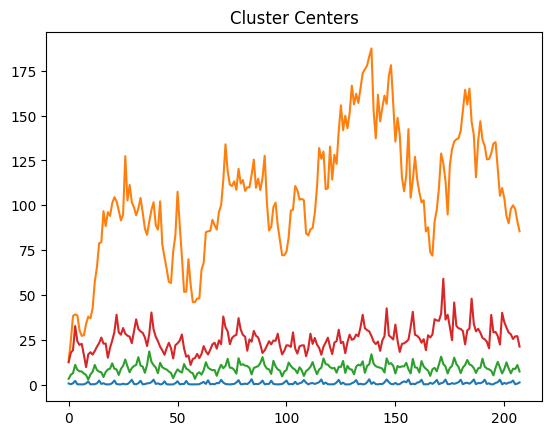

In [177]:
plt.plot(km_dtw_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

In [178]:
for i in range(n_clusters):
    print('Number of cities in cluster {}: {}'.format(i, (km_dtw.labels_ == i).sum()))

Number of cities in cluster 0: 636
Number of cities in cluster 1: 1
Number of cities in cluster 2: 66
Number of cities in cluster 3: 10


### 2.1.3 KShape

In [39]:
max_k = 10

sse_list_ks = []
silhouette_list_ks = []

for k in range(2, max_k + 1):
    
    time_init = time.time()
    ks = KShape(n_clusters=k, max_iter=100, random_state=2, n_init=10)
    ks.fit(X)

    if ks._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_ks.append(ks.inertia_)
    silhouette_list_ks.append(ts_silhouette_score(X, ks.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 32.369 s
Finished clustering for k = 3; time elapsed: 22.601 s
Finished clustering for k = 4; time elapsed: 29.386 s
Finished clustering for k = 5; time elapsed: 33.580 s
Finished clustering for k = 6; time elapsed: 35.897 s
Finished clustering for k = 7; time elapsed: 57.969 s
Finished clustering for k = 8; time elapsed: 44.030 s
Finished clustering for k = 9; time elapsed: 50.920 s
Finished clustering for k = 10; time elapsed: 52.063 s


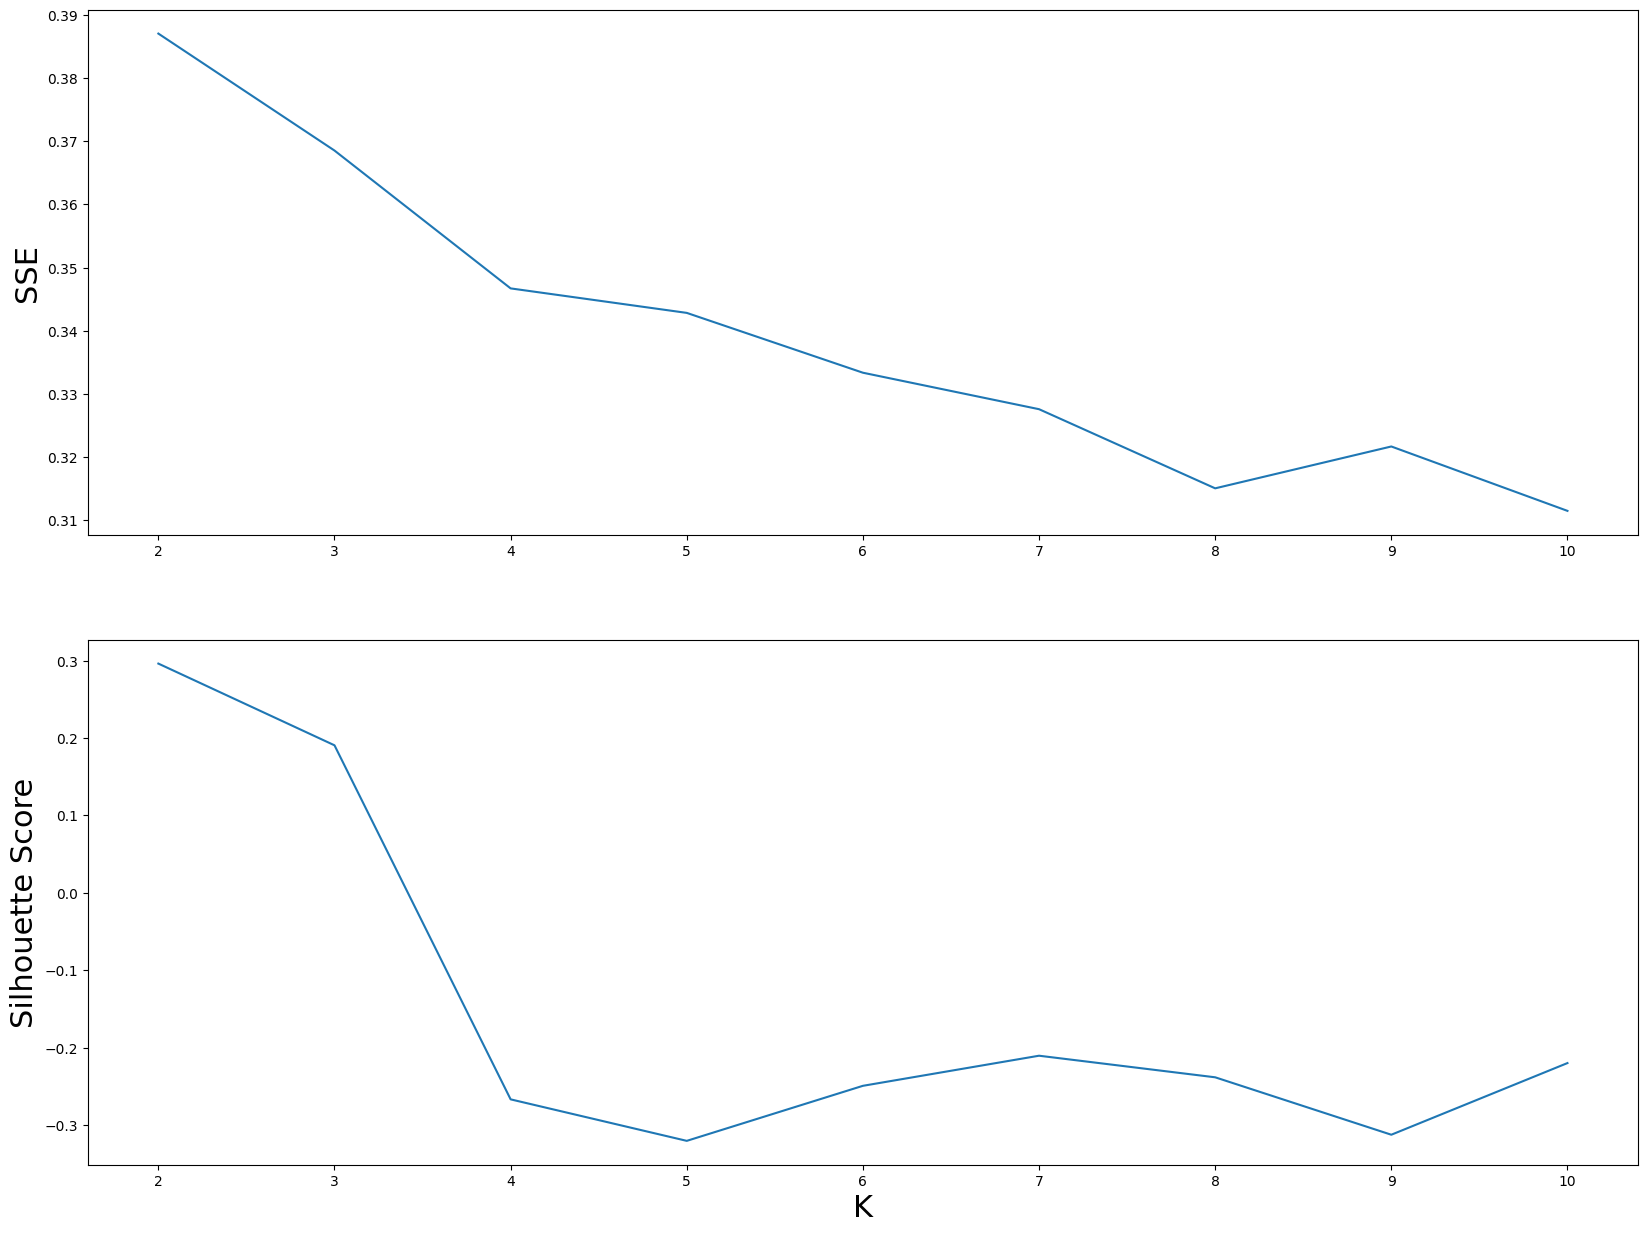

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_ks) + 2), sse_list_ks)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_ks) + 2))

ax[1].plot(range(2, len(silhouette_list_ks) + 2), silhouette_list_ks)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_ks) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [41]:
CHOSEN_K = 3

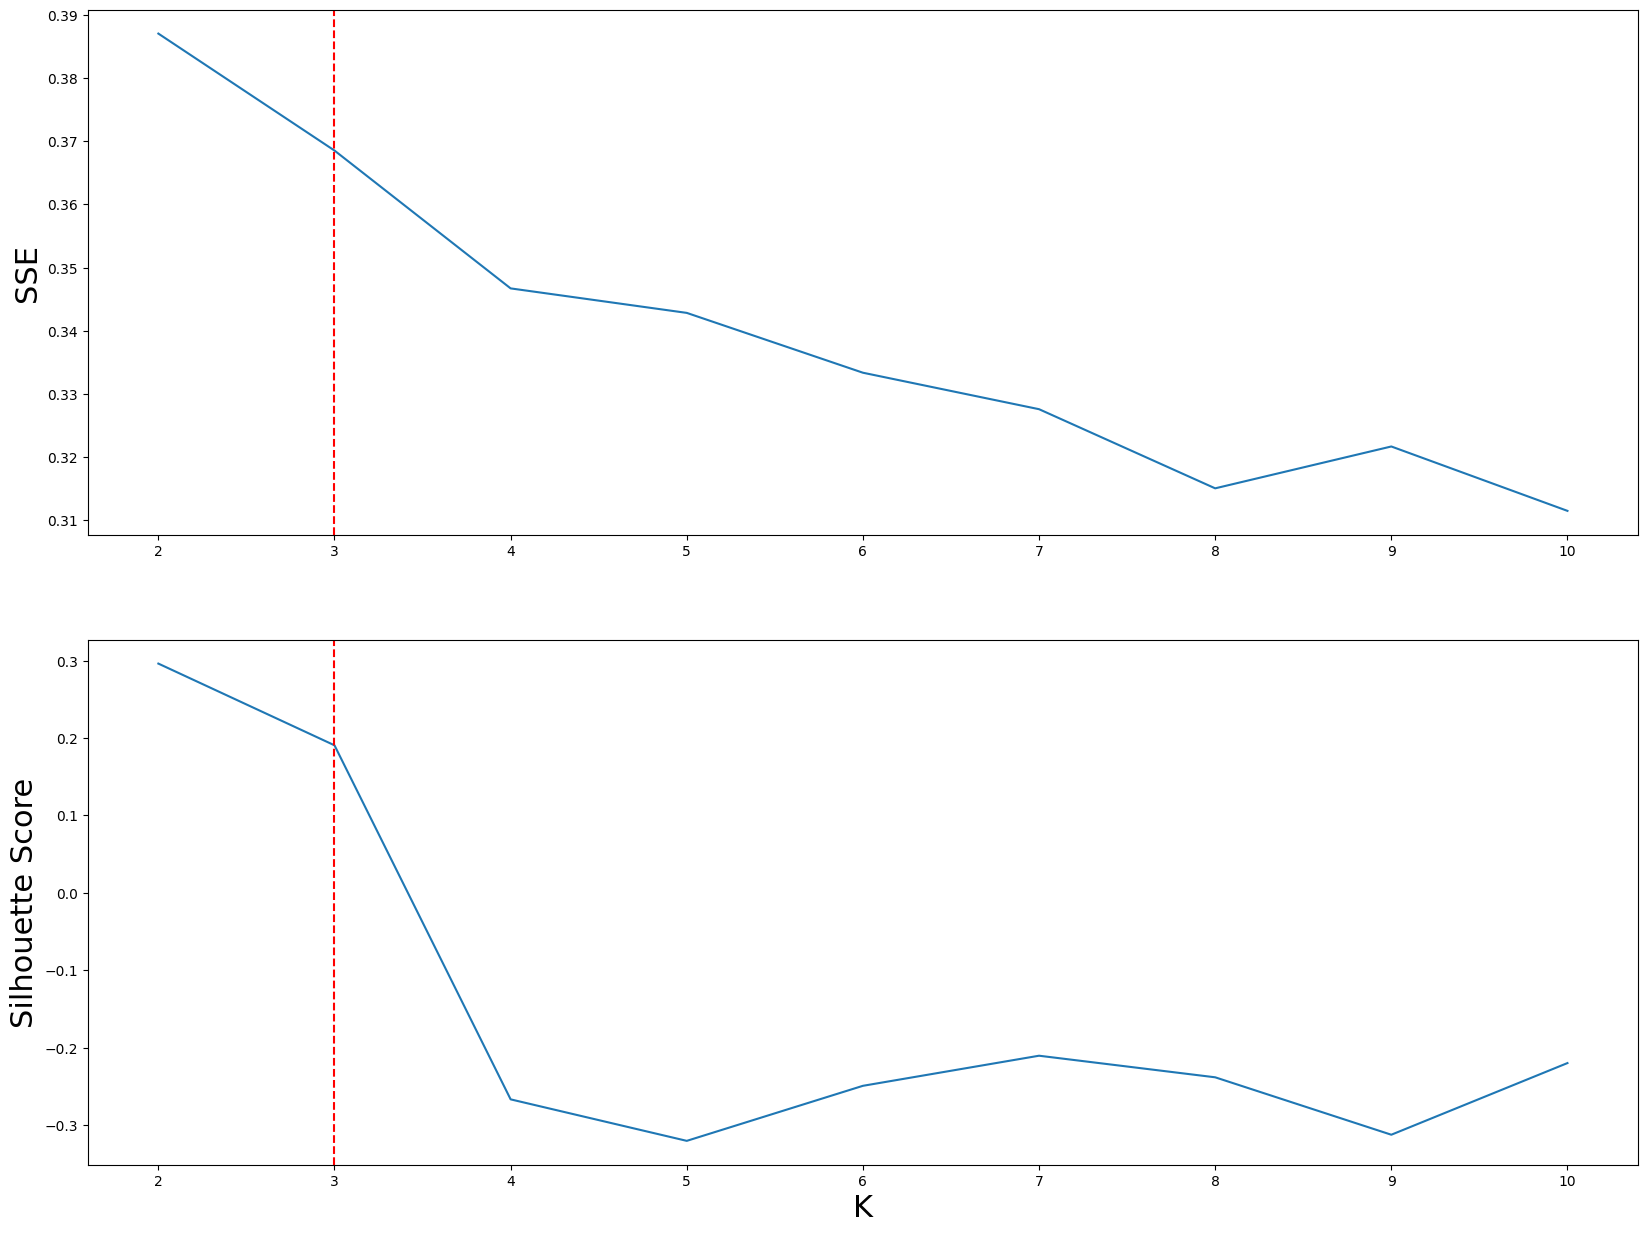

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_ks) + 2), sse_list_ks)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_ks) + 2))

ax[1].plot(range(2, len(silhouette_list_ks) + 2), silhouette_list_ks)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_ks) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [43]:
n_clusters = CHOSEN_K   
ks = KShape(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
ks.fit(X)

KShape(max_iter=1000, n_init=10, random_state=0)

In [44]:
ks_centers = scaler.inverse_transform(ks.cluster_centers_)

Inverse scaling time series with MinMaxScaler


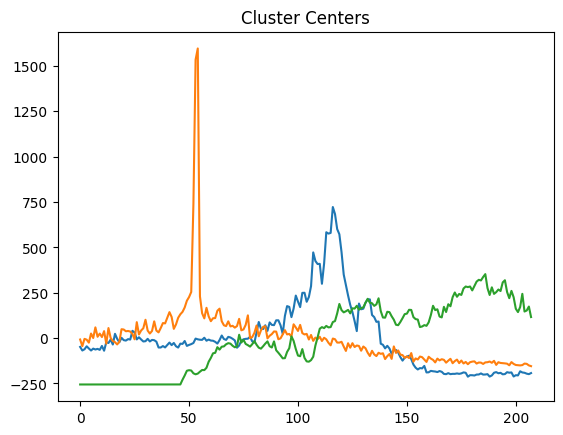

In [45]:
plt.plot(ks_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

In [46]:
# Inertia of the three algorithms
print("Inertia of the three algorithms:")
print("Euclidean k-means:", km.inertia_)
print("DTW k-means:", km_dtw.inertia_)
print("k-Shape:", ks.inertia_)

Inertia of the three algorithms:
Euclidean k-means: 0.05450885051766333
DTW k-means: 0.0416748493698539
k-Shape: 0.36075486271424734


## 2.2 Feature-based Clustering

In [47]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import Isomap, TSNE

In [48]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [49]:
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [50]:
F = [list(calculate_features(x).values())[:-2] for x in X]
F = np.array(F)


In [51]:
# repeat code for kmeans, only using features as metric
sse_list_km_features = []
silhouette_list_km_features = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_features = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    km_features.fit(F)

    if km_features.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_features.append(km_features.inertia_)        
    silhouette_list_km_features.append(silhouette_score(X, km_features.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Finished clustering for k = 2; time elapsed: 0.129 s
Finished clustering for k = 3; time elapsed: 0.031 s
Finished clustering for k = 4; time elapsed: 0.042 s
Finished clustering for k = 5; time elapsed: 0.039 s
Finished clustering for k = 6; time elapsed: 0.041 s
Finished clustering for k = 7; time elapsed: 0.041 s
Finished clustering for k = 8; time elapsed: 0.040 s
Finished clustering for k = 9; time elapsed: 0.040 s
Finished clustering for k = 10; time elapsed: 0.040 s


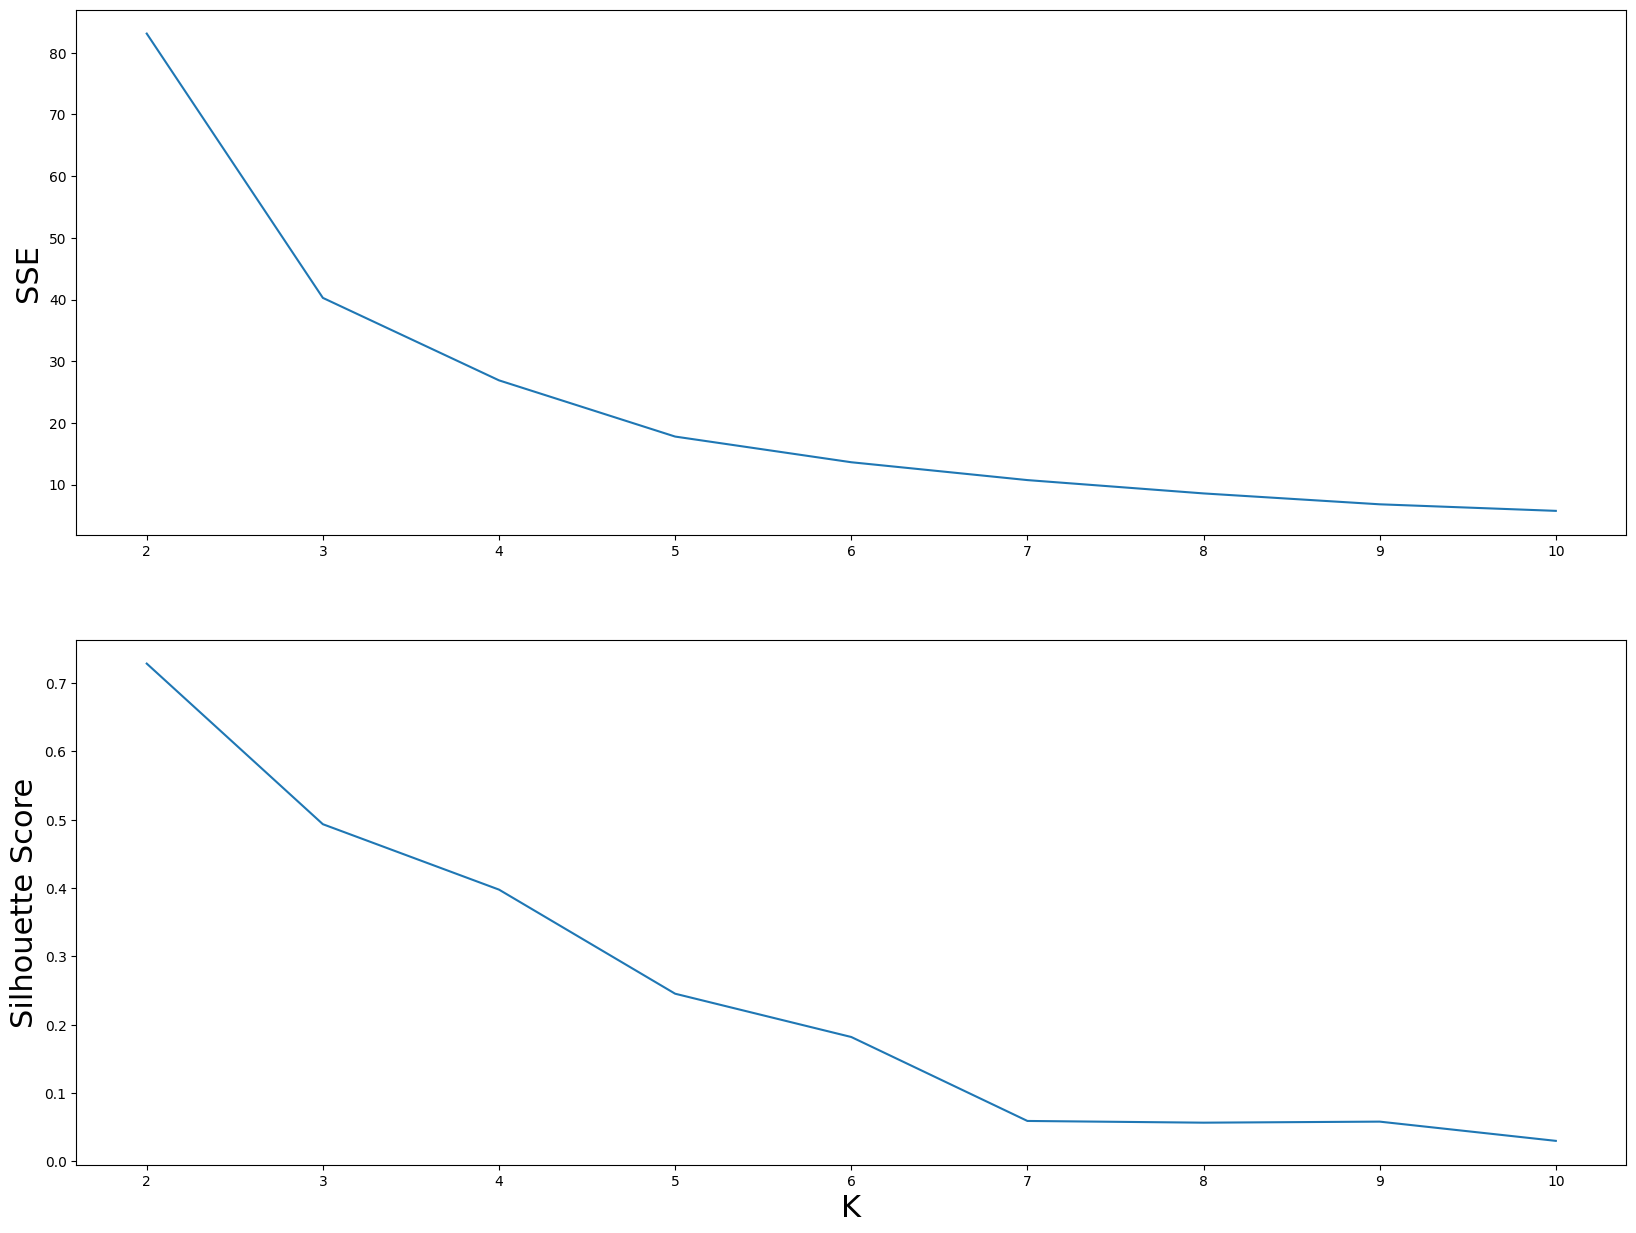

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [53]:
CHOSEN_K = 2

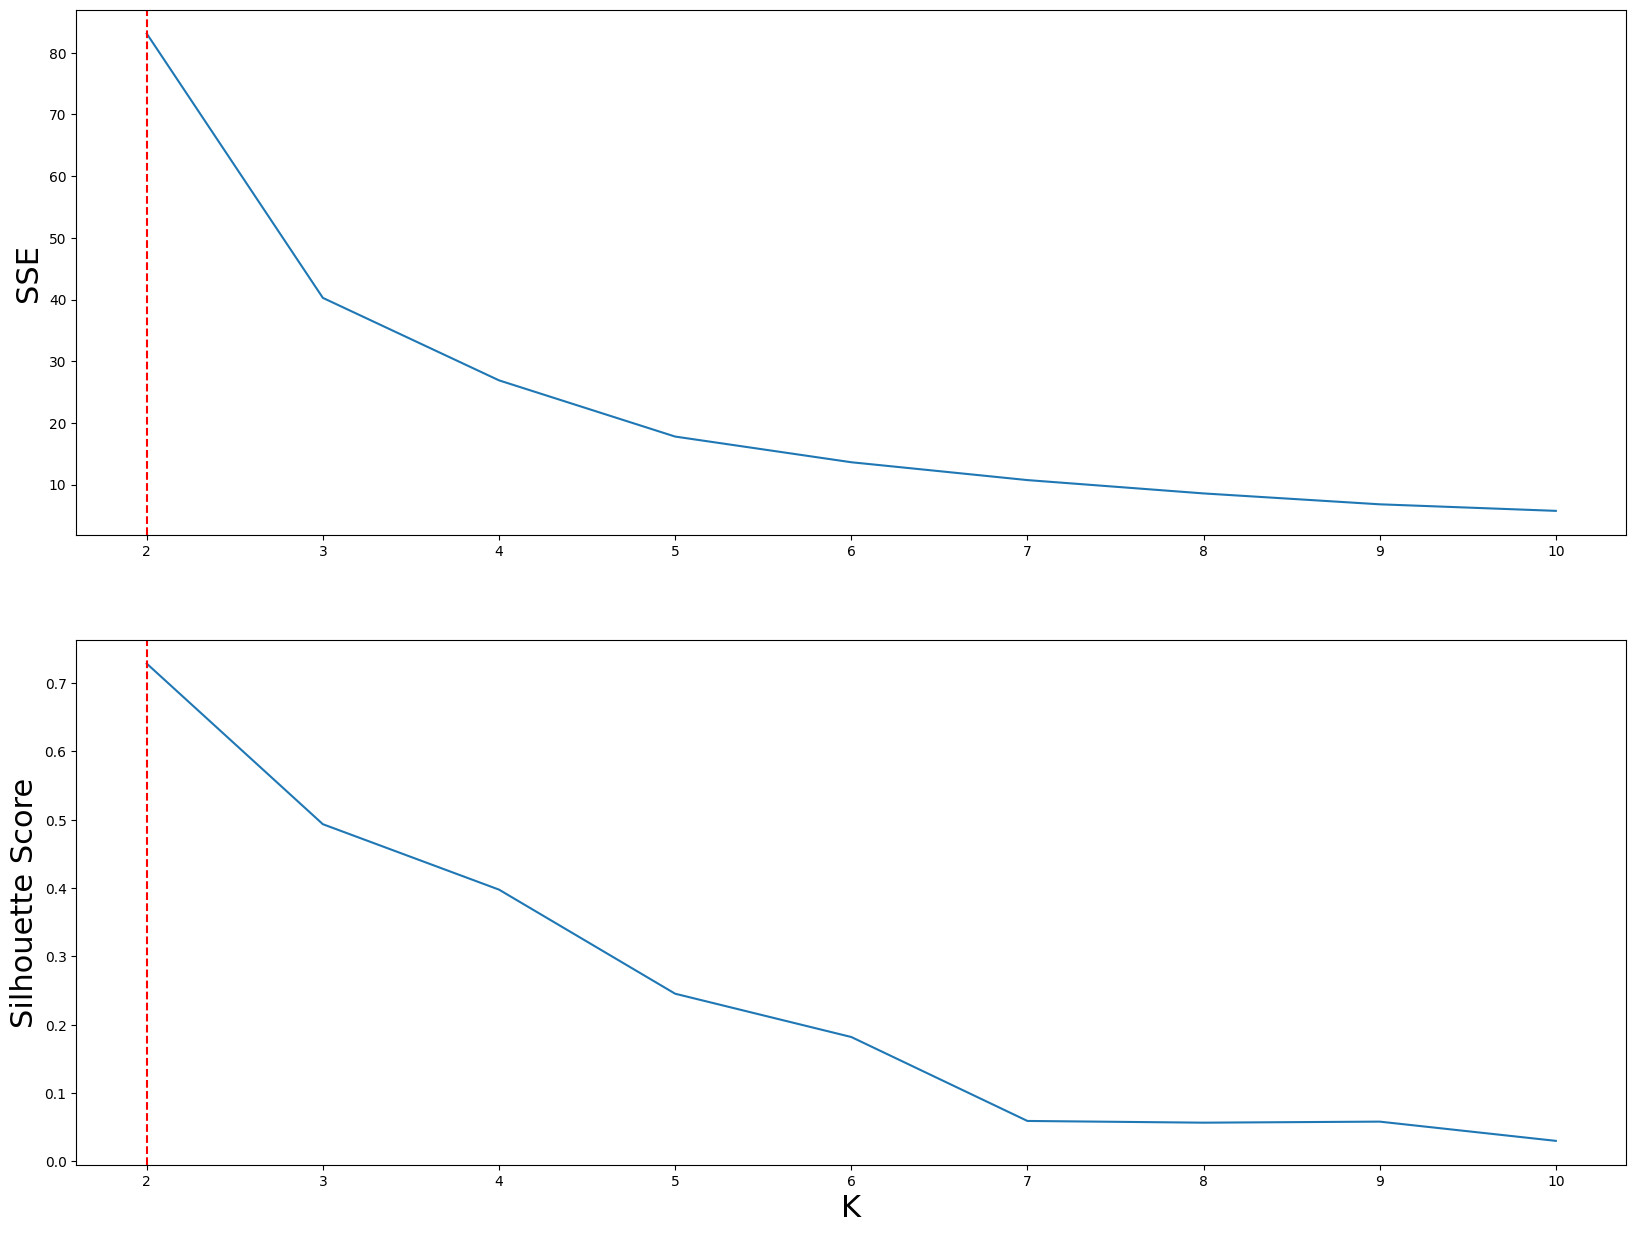

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [55]:
n_clusters = CHOSEN_K
km_features = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
km_features.fit(F)

KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=0)

In [56]:
import scipy.sparse as sp

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


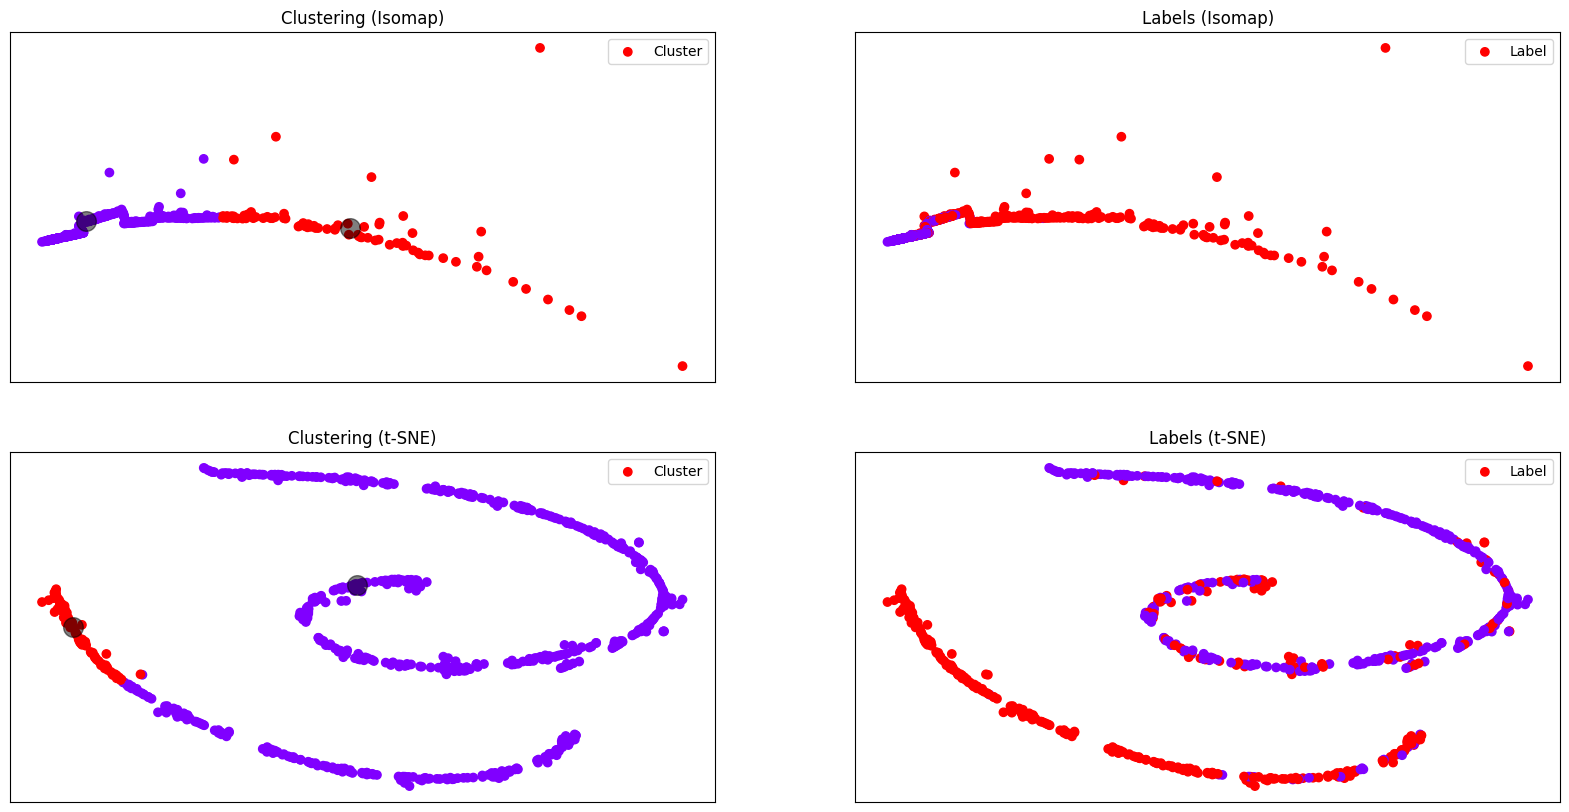

In [57]:
# Make an isomap representation of the datapoints and cluster centers

F_sparse = sp.csr_matrix(F)
F_lil = F_sparse.tolil()

iso = Isomap(n_components=2, n_neighbors=5, n_jobs=-1) 
iso.fit(F_lil)
X_iso = iso.transform(F_lil)
centers_iso = iso.transform(km_features.cluster_centers_)   

# Concatenate features and cluster centers, as tsne is transductive: there is no transform function to apply to cluster centers.
F_tsne = np.concatenate((F, km_features.cluster_centers_), axis=0)
tsne = TSNE(n_components=2, n_jobs=-1, init='random', perplexity=20)
X_tsne = tsne.fit_transform(F_tsne)
centers_tsne = X_tsne[-n_clusters:]
X_tsne = X_tsne[:-n_clusters]


# Do a doubple plot where one is based on clustering and the other is based on the labels
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Isomap - Clustering
scatter_iso_clustering = ax[0, 0].scatter(X_iso[:, 0], X_iso[:, 1], c=km_features.labels_, cmap='rainbow', label='Cluster')
ax[0, 0].scatter(centers_iso[:, 0], centers_iso[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[0, 0].set_title('Clustering (Isomap)')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

# Isomap - Labels
scatter_iso_labels = ax[0, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y, cmap='rainbow', label='Label')
ax[0, 1].set_title('Labels (Isomap)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

# t-SNE - Clustering
scatter_tsne_clustering = ax[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_features.labels_, cmap='rainbow', label='Cluster')
ax[1, 0].scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[1, 0].set_title('Clustering (t-SNE)')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

# t-SNE - Labels
scatter_tsne_labels = ax[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow', label='Label')
ax[1, 1].set_title('Labels (t-SNE)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

# Add Legends
legend_iso_clustering = ax[0, 0].legend(handles=[scatter_iso_clustering], loc='upper right')
legend_iso_labels = ax[0, 1].legend(handles=[scatter_iso_labels], loc='upper right')
legend_tsne_clustering = ax[1, 0].legend(handles=[scatter_tsne_clustering], loc='upper right')
legend_tsne_labels = ax[1, 1].legend(handles=[scatter_tsne_labels], loc='upper right')

plt.show()

In [58]:
print("Inertia of k-means with extracted features:", km_features.inertia_)

Inertia of k-means with extracted features: 83.11752395148473


## 2.3 Compression-based clustering

In [59]:
import zlib

In [60]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [61]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [62]:
# Do some clustering on this compression matrix M
max_k = 20

sse_list_km_comp = []
silhouette_list_km_comp = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km_comp = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    km_comp.fit(M)

    if km_comp.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_comp.append(km_comp.inertia_)
    silhouette_list_km_comp.append(silhouette_score(X, km_comp.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))


Finished clustering for k = 2; time elapsed: 0.051 s
Finished clustering for k = 3; time elapsed: 0.091 s
Finished clustering for k = 4; time elapsed: 0.070 s
Finished clustering for k = 5; time elapsed: 0.089 s
Finished clustering for k = 6; time elapsed: 0.081 s
Finished clustering for k = 7; time elapsed: 0.133 s
Finished clustering for k = 8; time elapsed: 0.111 s
Finished clustering for k = 9; time elapsed: 0.131 s
Finished clustering for k = 10; time elapsed: 0.124 s
Finished clustering for k = 11; time elapsed: 0.147 s
Finished clustering for k = 12; time elapsed: 0.122 s
Finished clustering for k = 13; time elapsed: 0.138 s
Finished clustering for k = 14; time elapsed: 0.133 s
Finished clustering for k = 15; time elapsed: 0.145 s
Finished clustering for k = 16; time elapsed: 0.137 s
Finished clustering for k = 17; time elapsed: 0.161 s
Finished clustering for k = 18; time elapsed: 0.155 s
Finished clustering for k = 19; time elapsed: 0.162 s
Finished clustering for k = 20; time

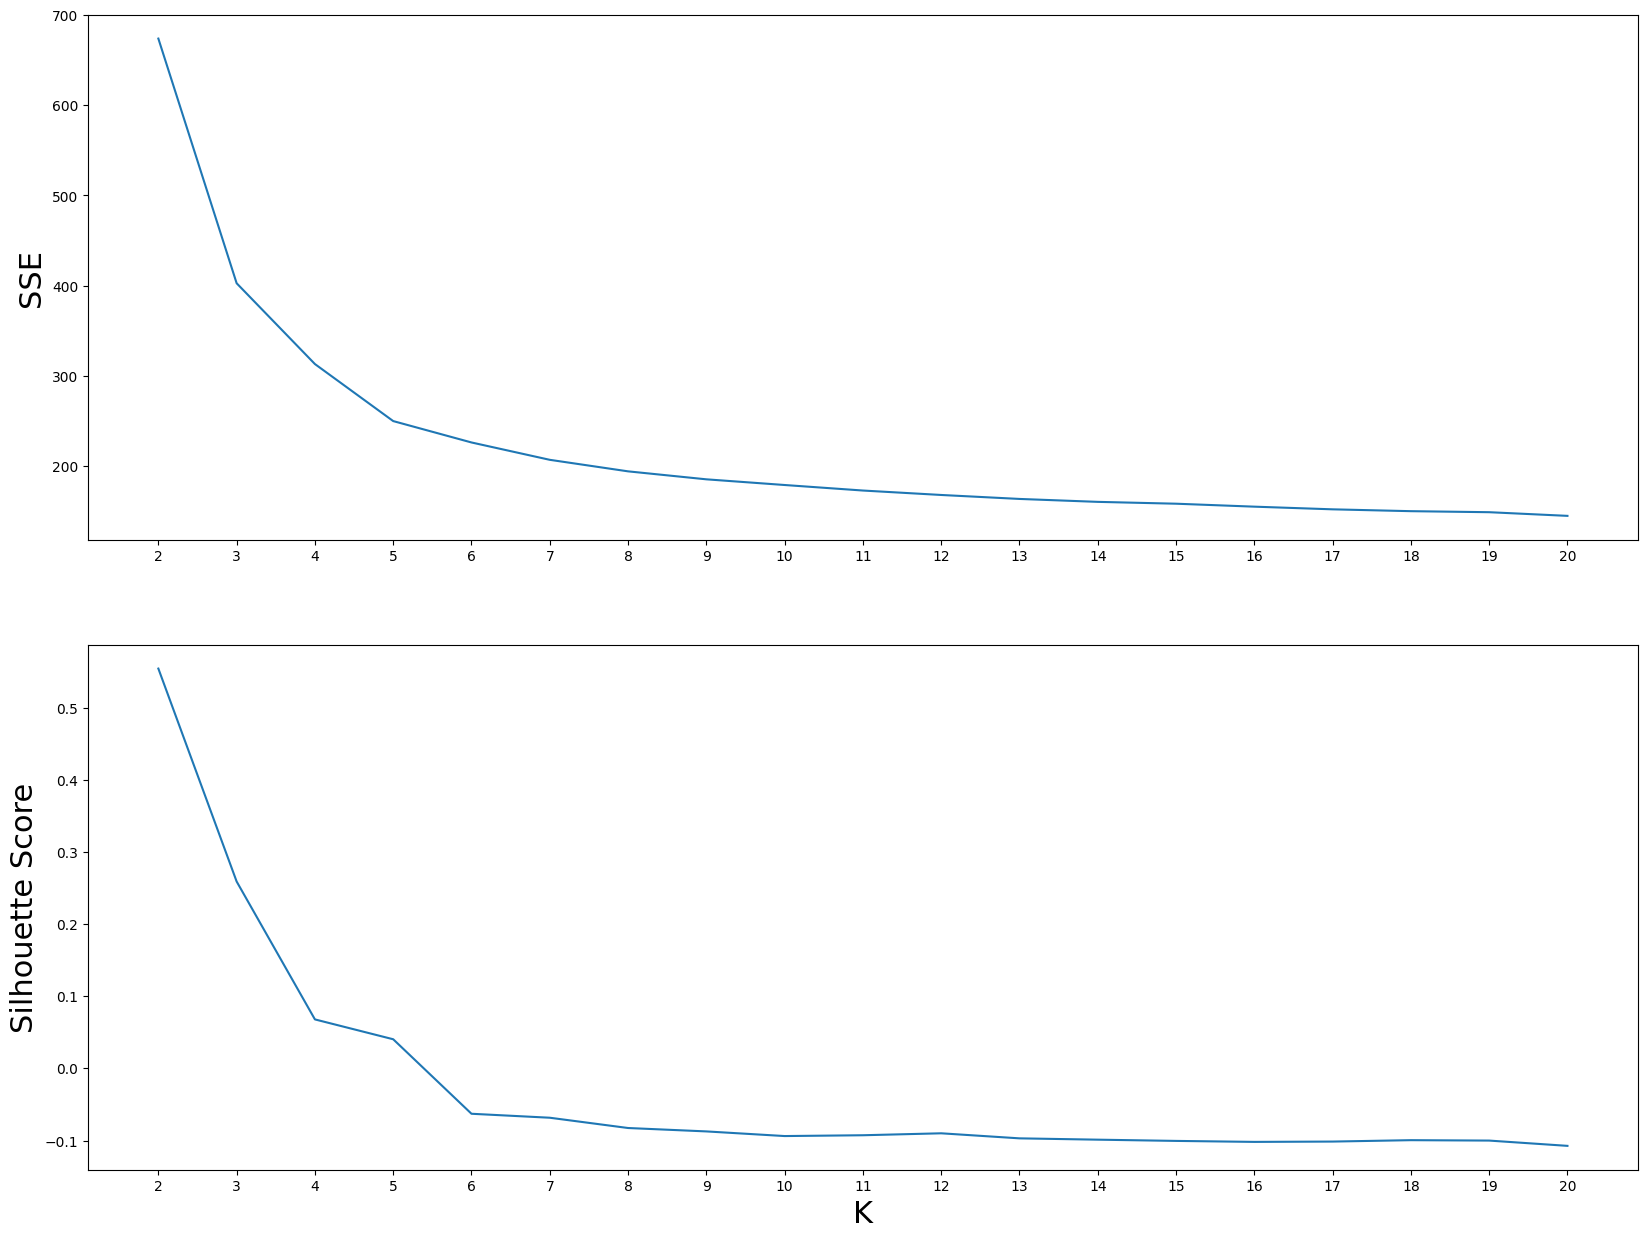

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_comp) + 2), sse_list_km_comp)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_comp) + 2))

ax[1].plot(range(2, len(silhouette_list_km_comp) + 2), silhouette_list_km_comp)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_comp) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

In [64]:
CHOSEN_K = 2

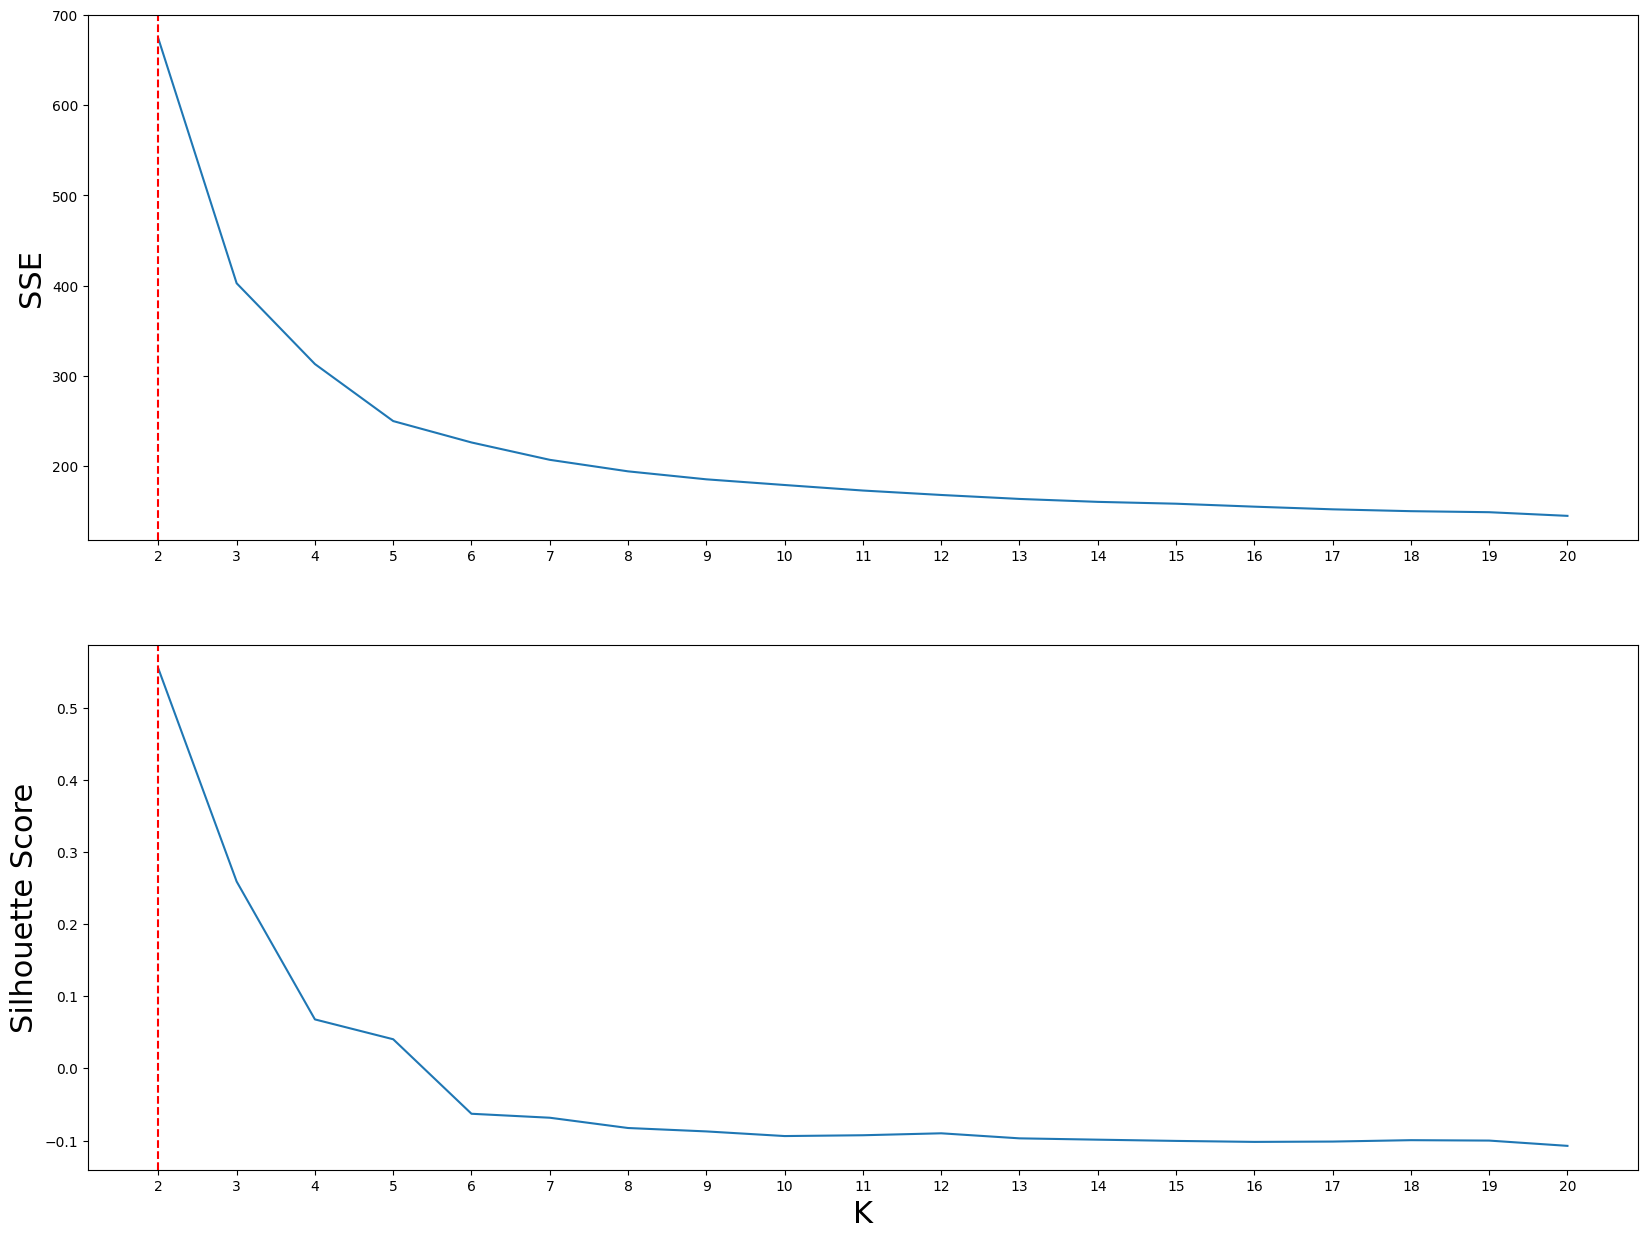

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_comp) + 2), sse_list_km_comp)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_comp) + 2))

ax[1].plot(range(2, len(silhouette_list_km_comp) + 2), silhouette_list_km_comp)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_comp) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [66]:
n_clusters = CHOSEN_K
km_comp = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
km_comp.fit(M)

KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=0)

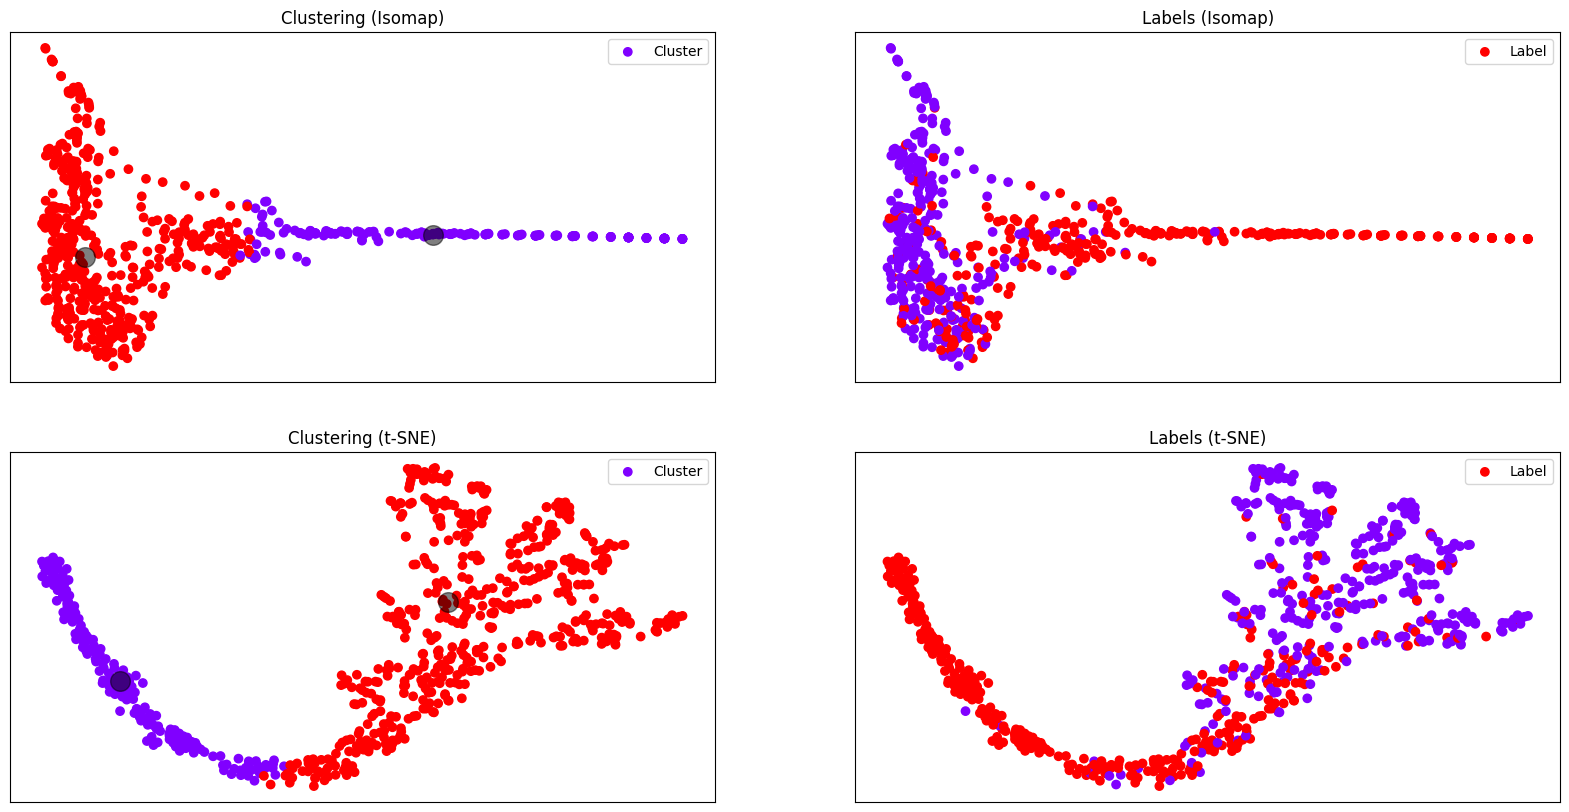

In [67]:
# Make an isomap representation of the datapoints and cluster centers

M_sparse = sp.csr_matrix(M)
M_lil = M_sparse.tolil()

iso = Isomap(n_components=2, n_neighbors=5, n_jobs=-1) 
iso.fit(M_lil)
X_iso = iso.transform(M_lil)
centers_iso = iso.transform(km_comp.cluster_centers_)   

# Concatenate comp and cluster centers, as tsne is transductive: there is no transform function to apply to cluster centers.
M_tsne = np.concatenate((M, km_comp.cluster_centers_), axis=0)
tsne = TSNE(n_components=2, n_jobs=-1, init='random', perplexity=20)
X_tsne = tsne.fit_transform(M_tsne)
centers_tsne = X_tsne[-n_clusters:]
X_tsne = X_tsne[:-n_clusters]


# Do a doubple plot where one is based on clustering and the other is based on the labels
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Isomap - Clustering
scatter_iso_clustering = ax[0, 0].scatter(X_iso[:, 0], X_iso[:, 1], c=km_comp.labels_, cmap='rainbow', label='Cluster')
ax[0, 0].scatter(centers_iso[:, 0], centers_iso[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[0, 0].set_title('Clustering (Isomap)')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

# Isomap - Labels
scatter_iso_labels = ax[0, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y, cmap='rainbow', label='Label')
ax[0, 1].set_title('Labels (Isomap)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

# t-SNE - Clustering
scatter_tsne_clustering = ax[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_comp.labels_, cmap='rainbow', label='Cluster')
ax[1, 0].scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[1, 0].set_title('Clustering (t-SNE)')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

# t-SNE - Labels
scatter_tsne_labels = ax[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow', label='Label')
ax[1, 1].set_title('Labels (t-SNE)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

# Add Legends
legend_iso_clustering = ax[0, 0].legend(handles=[scatter_iso_clustering], loc='upper right')
legend_iso_labels = ax[0, 1].legend(handles=[scatter_iso_labels], loc='upper right')
legend_tsne_clustering = ax[1, 0].legend(handles=[scatter_tsne_clustering], loc='upper right')
legend_tsne_labels = ax[1, 1].legend(handles=[scatter_tsne_labels], loc='upper right')

plt.show()


## 2.5 Approximation-based clustering

In [68]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [69]:
n_paa_segments = 20
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.inverse_transform(paa.fit_transform(X))

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 713 1-dimensional timeseries
  warnings.warn(


In [70]:
# repeat code for kmeans

sse_list_km_paa = []
silhouette_list_km_paa = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km_paa = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100, random_state=0, n_init=10)
    km_paa.fit(X_paa)

    if km_paa.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_paa.append(km_paa.inertia_)
    silhouette_list_km_paa.append(ts_silhouette_score(X, km_paa.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 2.699 s
Finished clustering for k = 3; time elapsed: 4.657 s
Finished clustering for k = 4; time elapsed: 6.010 s
Finished clustering for k = 5; time elapsed: 4.358 s
Finished clustering for k = 6; time elapsed: 4.991 s
Finished clustering for k = 7; time elapsed: 6.303 s
Finished clustering for k = 8; time elapsed: 4.504 s
Finished clustering for k = 9; time elapsed: 4.355 s
Finished clustering for k = 10; time elapsed: 4.250 s
Finished clustering for k = 11; time elapsed: 5.063 s
Finished clustering for k = 12; time elapsed: 4.816 s
Finished clustering for k = 13; time elapsed: 4.827 s
Finished clustering for k = 14; time elapsed: 4.937 s
Finished clustering for k = 15; time elapsed: 5.315 s
Finished clustering for k = 16; time elapsed: 5.386 s
Finished clustering for k = 17; time elapsed: 5.450 s
Finished clustering for k = 18; time elapsed: 5.159 s
Finished clustering for k = 19; time elapsed: 5.664 s
Finished clustering for k = 20; time

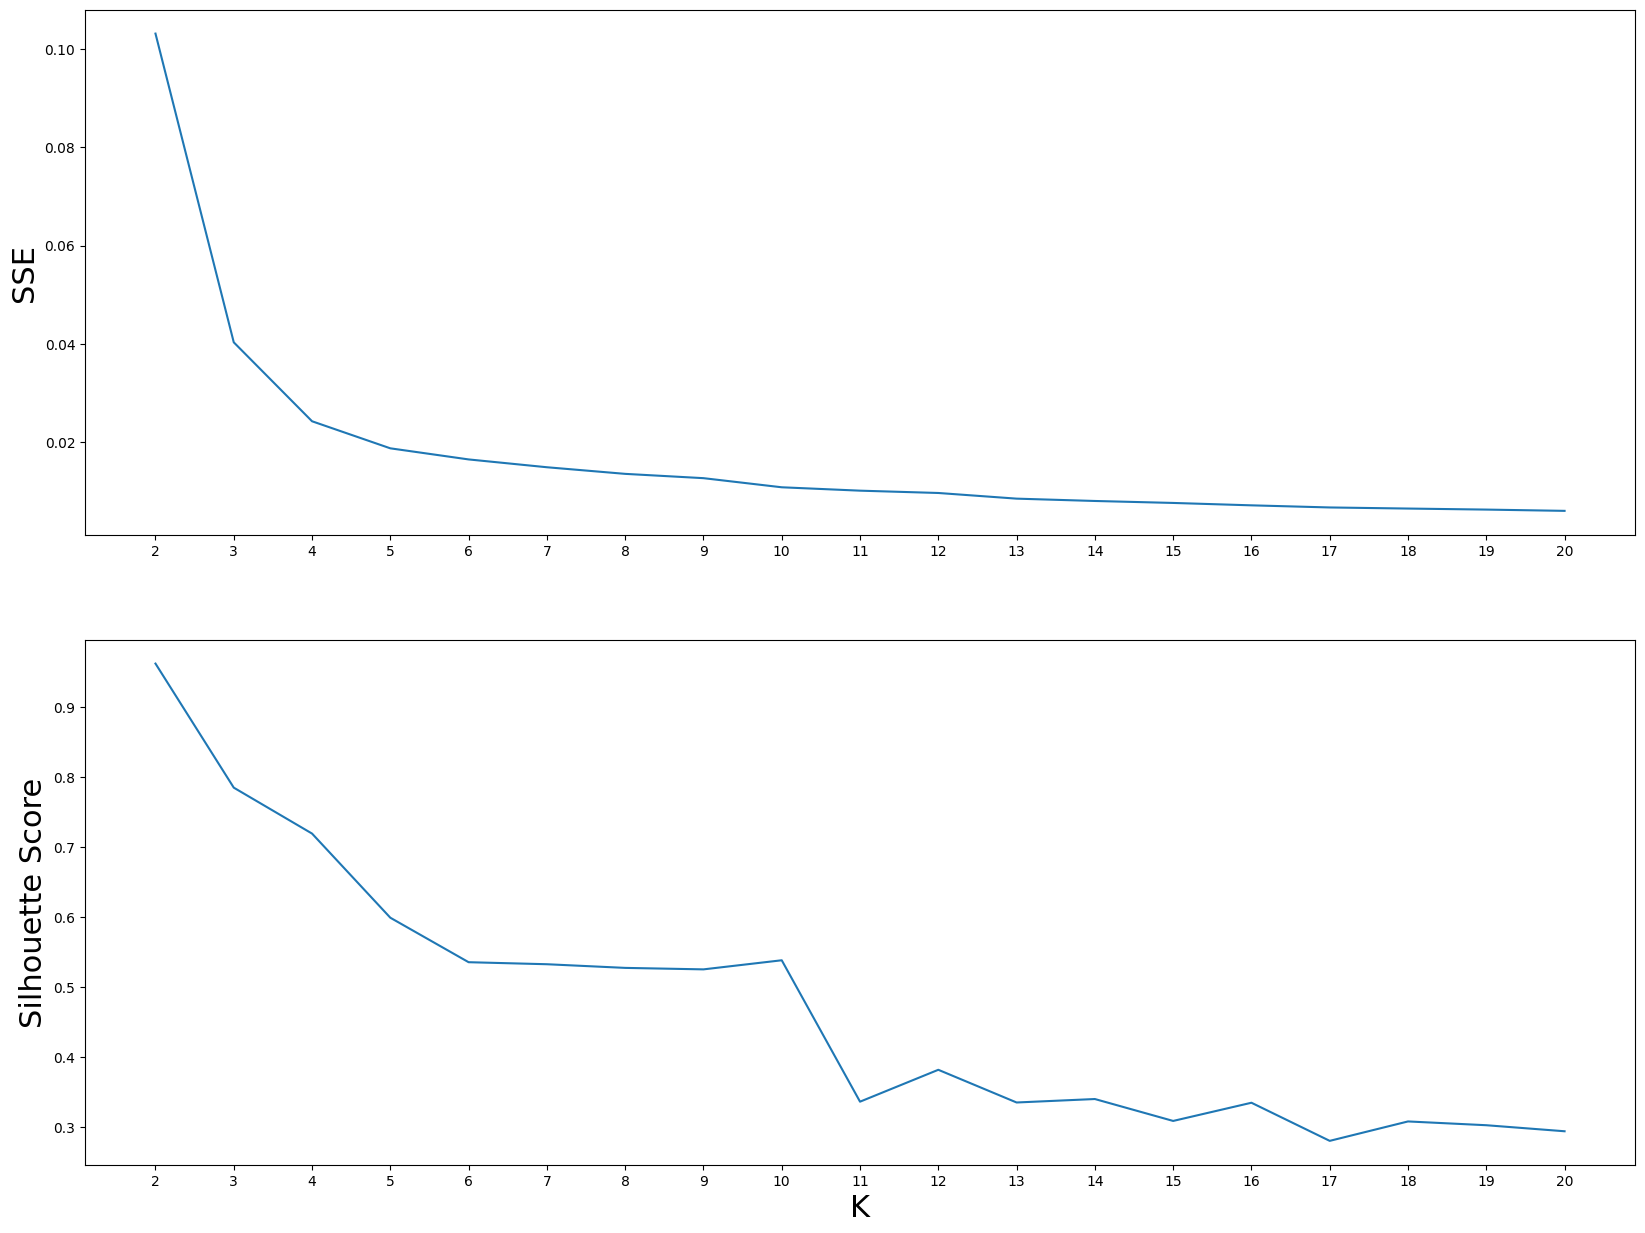

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_paa) + 2), sse_list_km_paa)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_paa) + 2))

ax[1].plot(range(2, len(silhouette_list_km_paa) + 2), silhouette_list_km_paa)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_paa) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [162]:
CHOSEN_K = 4

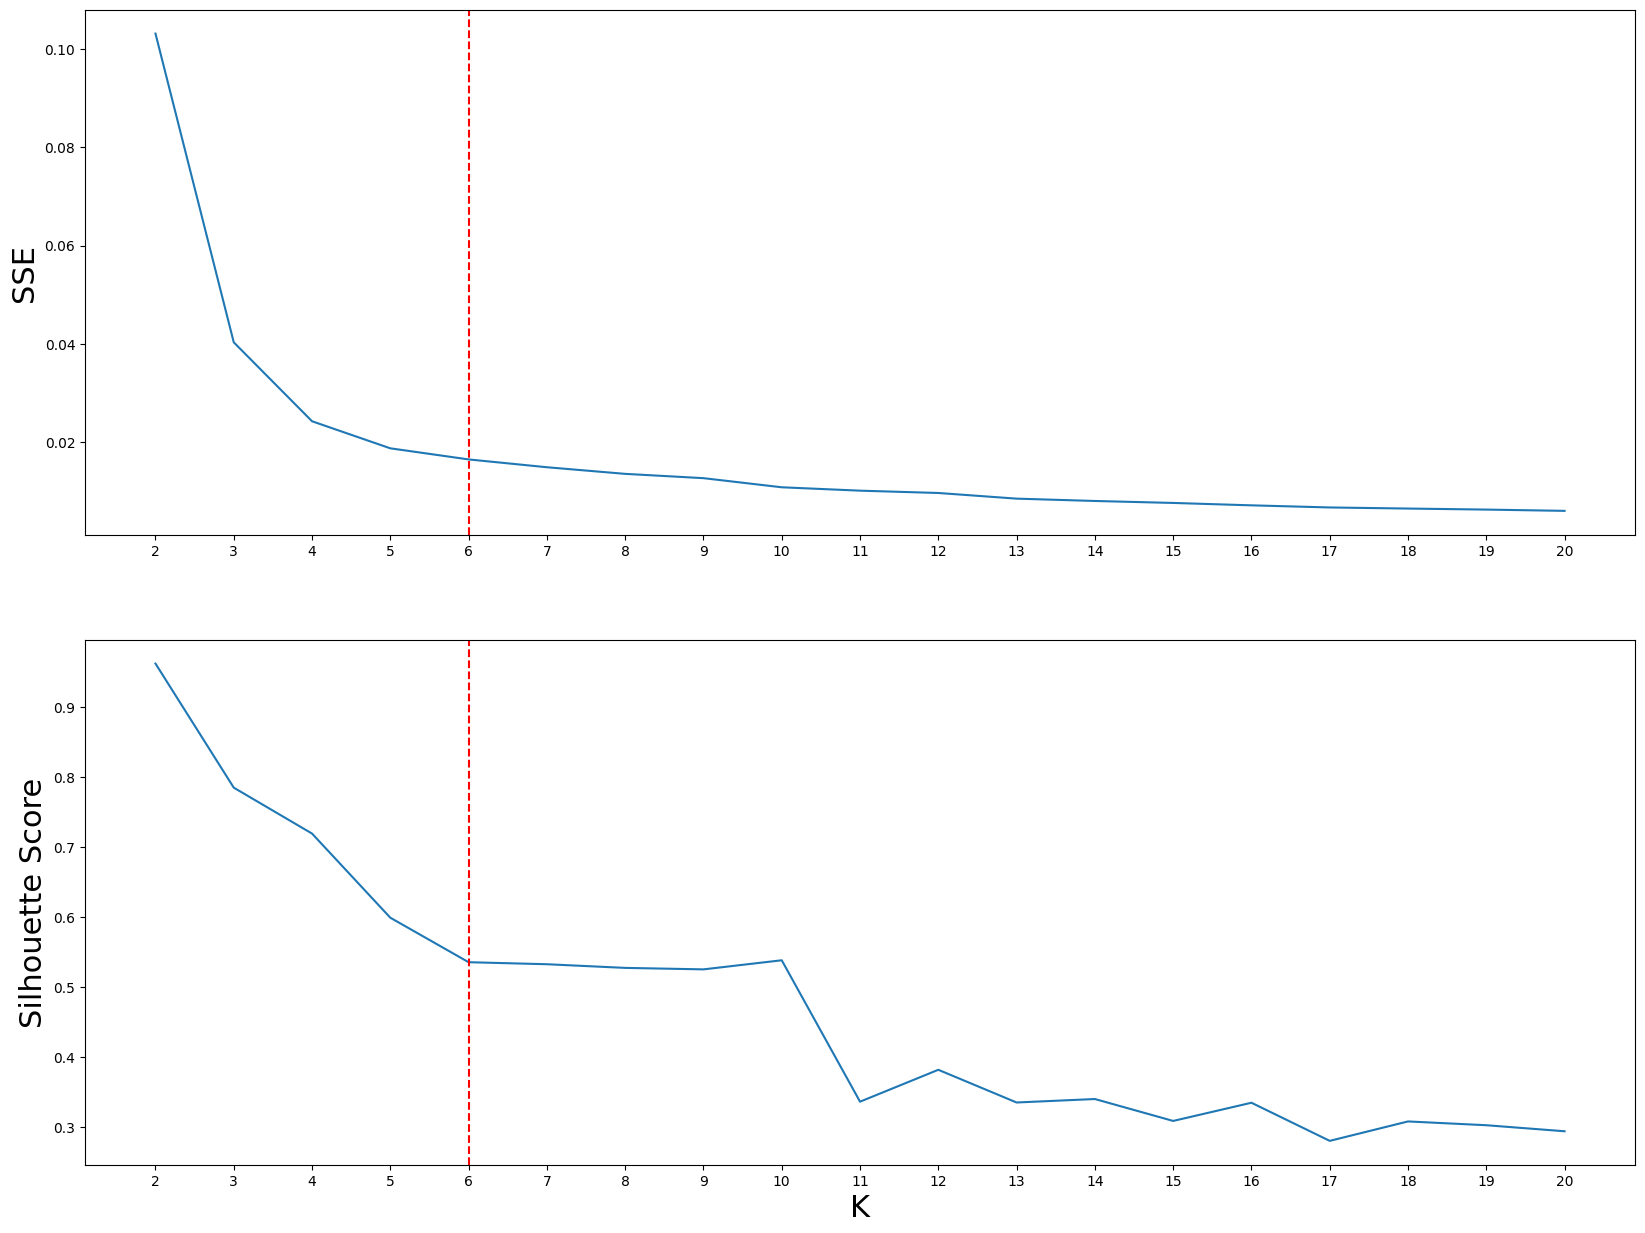

In [163]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_paa) + 2), sse_list_km_paa)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_paa) + 2))

ax[1].plot(range(2, len(silhouette_list_km_paa) + 2), silhouette_list_km_paa)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_paa) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [164]:
n_clusters = CHOSEN_K
km_paa = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=1000, random_state=0, n_init=10)
km_paa.fit(X_paa)

TimeSeriesKMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=0)

In [165]:
km_paa_centers = scaler.inverse_transform(km_paa.cluster_centers_)

Inverse scaling time series with MinMaxScaler


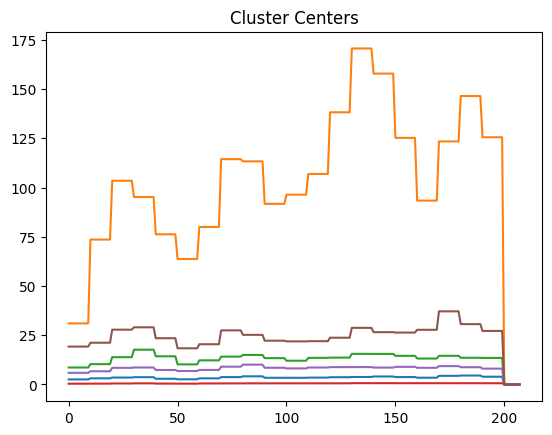

In [166]:
plt.plot(km_paa_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

Recompute the centroid from time series in cluster.

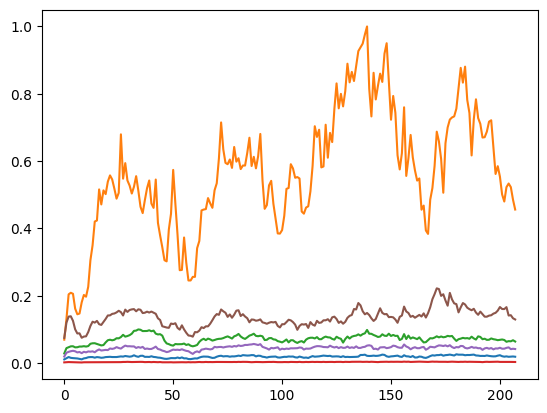

In [167]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km_paa.labels_ == i)[0]], axis=0))
plt.show()

In [168]:
for i in range(n_clusters):
    print(f'Number of points in cluster {i}: {np.where(km_paa.labels_ == i)[0].shape[0]}')

Number of points in cluster 0: 85
Number of points in cluster 1: 1
Number of points in cluster 2: 19
Number of points in cluster 3: 566
Number of points in cluster 4: 32
Number of points in cluster 5: 10


# 3. Motif Extraction

In [154]:
import stumpy

In [79]:
cities.shape

(713,)

In [80]:
"""
# Stumpy library calculates the matrix profile for a given time series
# Select the city with most weeks with incidents in the dataset and calculate its matrix profile
non_zero_values = np.count_nonzero(X, axis=1)
city_index = np.argmax(non_zero_values)
city = cities[city_index]

ts = X[city_index]  
print('City with most weeks with incidents:', city)
print('Number of weeks with incidents:', non_zero_values[city_index])
ts = ts.reshape(ts.shape[0])
ts.shape
"""

city = 'CHICAGO'

# Find index of city in the cities array of cities
city_index = np.where(cities == city)

# Get the time series of the city
ts = X[city_index]
ts = ts.reshape(ts.shape[1])


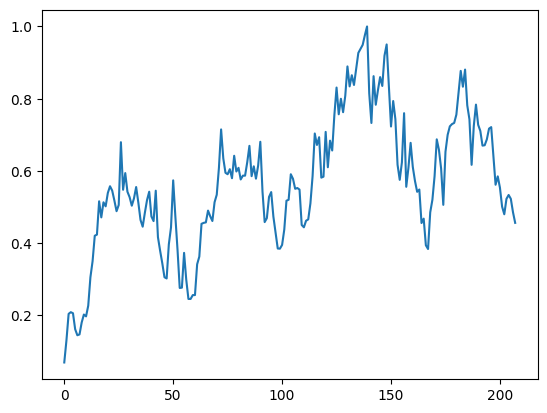

In [81]:
# Plot the time series
plt.plot(ts)

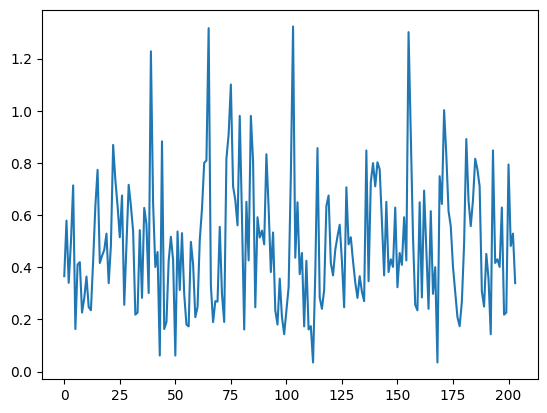

In [82]:
w = 5
mp = stumpy.stump(ts, w)[:, 0]

plt.plot(mp)
plt.show()

In [83]:
# Find the motifs and their locations
motif_dist, motif_idx = stumpy.motifs(ts, mp, max_motifs=5)

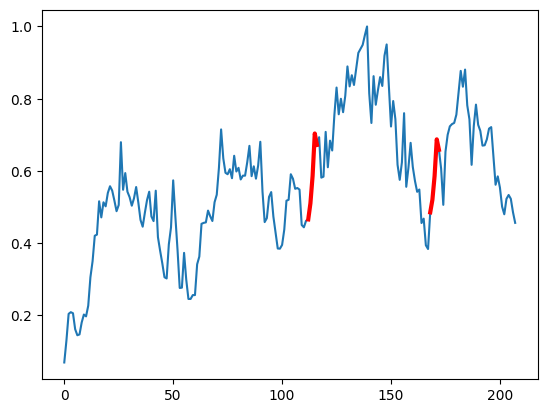

In [84]:
plt.plot(ts)

colors = ['r', 'g', 'k', 'b', 'y'][:len(motif_dist)]

for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)

plt.show()

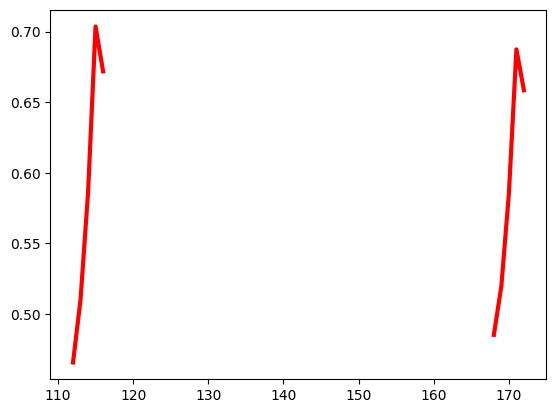

In [85]:
for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
    plt.show()

# 4. Anomaly Detection

Calculate anomalies as out of distribution values of the matrix profile.

In [86]:
# Calculate z-scores for the matrix profile
z_scores = stats.zscore(mp.tolist())

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Find anomalies based on the threshold
anomalies = np.where(np.abs(z_scores) > threshold)[0]

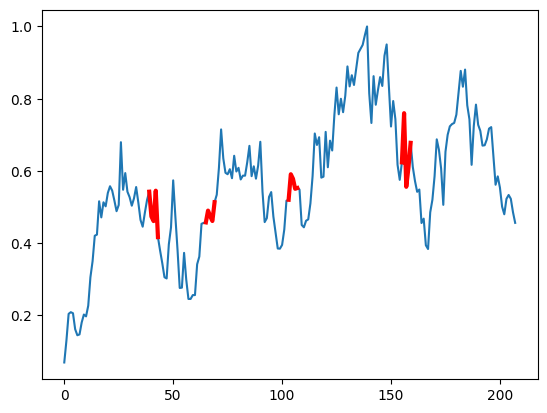

In [87]:
plt.plot(ts)
for a in anomalies:
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color='r', lw=3)

plt.show()

# 5. Shapelet Extraction

In [88]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-01-06 13:38:34.911908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 5.1 Dataset preparation with labelling

In [89]:
# See how many time series in dataset have at least one killing and how many don't
# This is the label for the shapelet learning task
print(f'Number of time series with at least {ISKILLED_THRESHOLD} killings:', np.sum(y))
print('Number of time series with no killings:', y.shape[0] - np.sum(y))

Number of time series with at least 25 killings: 341
Number of time series with no killings: 372


In [126]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

## 5.2 Shapelet Discovery

Define the hyperparameters.

In [91]:
# Define hyperparams
n_ts, ts_sz = X_train.shape[:2]
l = 0.05
r = 4

In [92]:
# Follow github repo https://github.com/stephanielees/shapeletsLTS-humansensor/blob/main/shapelet-tslearn.ipynb
PERCENTAGE = 0.5
# Select randomly 10% of the time series in the training set to extract shapelets from
indexes = np.random.choice(X_train.shape[0], int(X_train.shape[0] * PERCENTAGE), replace=False)
X_train_small = X_train[indexes]
y_train_small = y_train[indexes]

In [93]:
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts = n_ts, ts_sz = ts_sz, n_classes = 2, l = l, r = r)
shapelet_dict

{10: 4, 20: 4, 30: 4, 40: 4}

Generate shapelets on the small training set and then use those shapelets for doing the shapelet transform on all setes: the full training set, the validation set and the test set. We will then use these resulting shapelet-transformed sets to train the classifier.

In [94]:
trans = LearningShapelets(n_shapelets_per_size= shapelet_dict, weight_regularizer=0.01, batch_size=32, max_iter=2500,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), scale=False)

# Fit the model
trans.fit(X_train_small, y_train_small)
shapelets_learned = trans.shapelets_
shapelets_learned_as_ts = trans.shapelets_as_time_series_

X_train = trans.transform(X_train)
X_valid = trans.transform(X_val)
X_test = trans.transform(X_test)

print('Shapelet transform performed, returning array of shape=(n_ts, n_shapelets) of distances to each shapelet')
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print('Number of shapelets according to the shapelet dictionary:', sum(shapelet_dict.values()))
print('Actual number of shapelets learned:', shapelets_learned.shape[0])

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet transform performed, returning array of shape=(n_ts, n_shapelets) of distances to each shapelet
(456, 16)
(114, 16)
(143, 16)
Number of shapelets according to the shapelet dictionary: 16
Actual number of shapelets learned: 16


In [95]:
print('Shape of shapelets learned as time series:', shapelets_learned_as_ts.shape)
print('Shape of shapelets learned:', shapelets_learned.shape)  

Shape of shapelets learned as time series: (16, 40, 1)
Shape of shapelets learned: (16,)


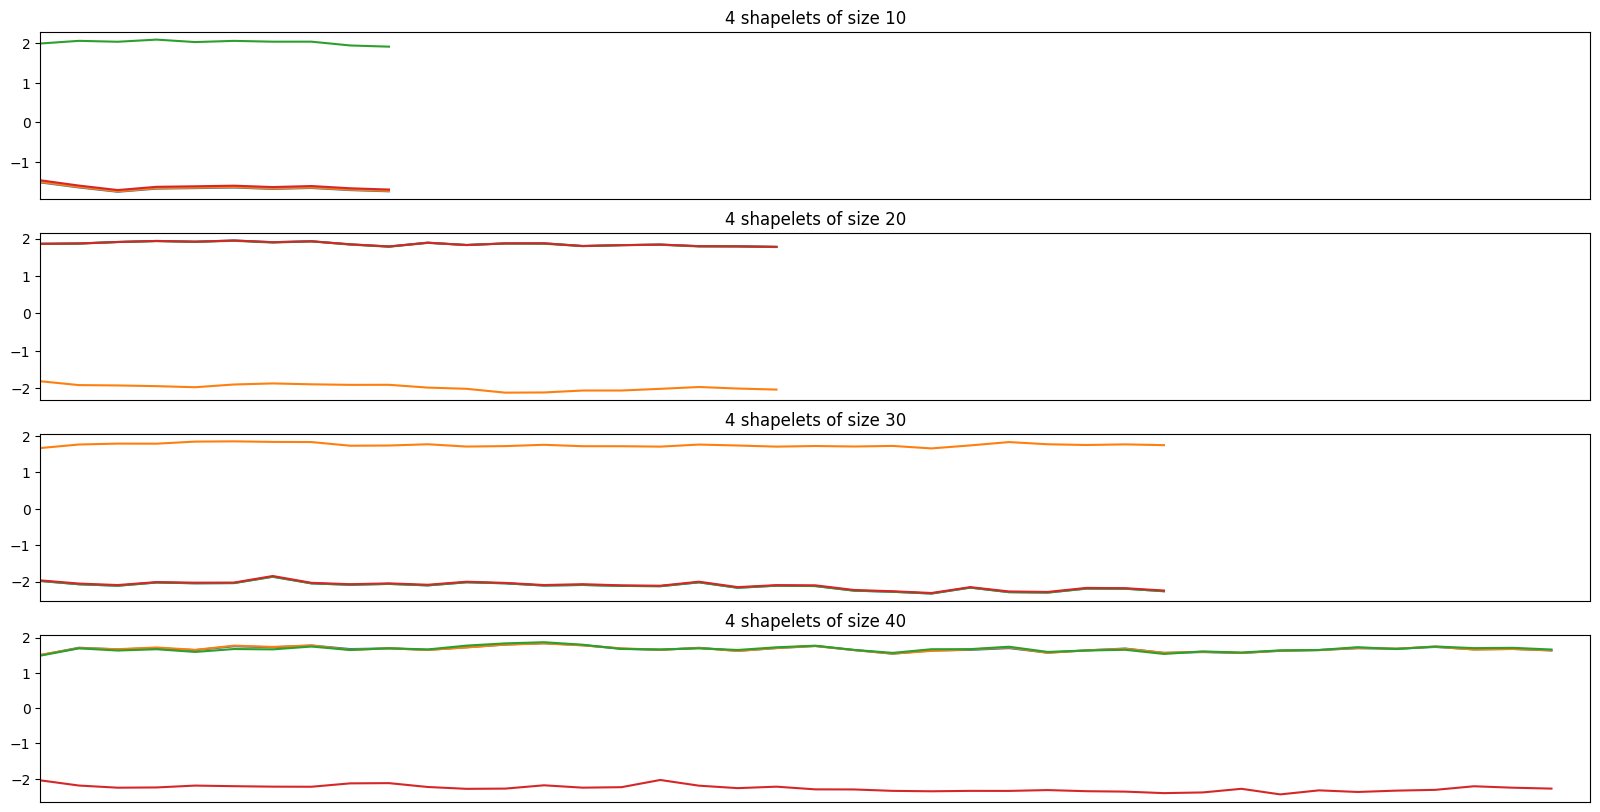

In [96]:
# Show the shapelets that are as many as we calculated in the dictionary
n_shapelet_sizes = len(shapelet_dict.keys())
max_shapelet_size = max(shapelet_dict.keys())

plt.figure(figsize=(20, 10))
for i, sz in enumerate(shapelet_dict.keys()):
    plt.subplot(n_shapelet_sizes, 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_dict[sz], sz))
    for sh_idx in range(shapelet_dict[sz]):
        plt.plot(shapelets_learned_as_ts[sh_idx + sum(list(shapelet_dict.values())[:i])].ravel())
        plt.xlim([0, max_shapelet_size])
        plt.xticks([])

As explained in the paper, multiple similar shapelets is not necessarily a bad thing. In ML, generally, having two similar features might cause multicollinearity and bias, but in the case of shapelets, one shapelet might not be able to separate the data, so multiple similar shapelets may be actually useful.

Paper: https://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## 5.3 Classification with Shapelets

In [110]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint as sp_randint

In [111]:
# For approaches with CV, merge train and validation sets
X_train_val = np.concatenate((X_train, X_valid))
y_train_val = np.concatenate((y_train, y_valid))

### 5.3.1 K-nn

In [112]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski')
param_dist = {"n_neighbors": [1, 3, 5, 10, 20]}

grid_search = GridSearchCV(knn, param_grid=param_dist,
                                 n_jobs=-1,
                                 scoring='accuracy')

grid_search.fit(X_train_val, y_train_val)

GridSearchCV(estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]}, scoring='accuracy')

In [113]:
best_knn = grid_search.best_estimator_
best_knn_hp = grid_search.best_params_
print('Best setting params ', best_knn_hp)  
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting params  {'n_neighbors': 10}
Mean and std of this setting  0.8210526315789475 0.03746343246326775


### 5.3.2 Random Forest

In [114]:
random_forest = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [3, 5, 7, 10, None],
              "max_features": sp_randint(1, X_train_val.shape[0] + 1),
              "min_samples_split": sp_randint(20, 51),
              "min_samples_leaf": sp_randint(20, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}

random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=-1,
                                scoring='accuracy')

random_search.fit(X_train_val, y_train_val)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f94d100>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1869d5fd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f99fe20>},
                   scoring='accuracy')

In [115]:
best_rf = random_search.best_estimator_
best_rf_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_rf_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 485, 'min_samples_leaf': 33, 'min_samples_split': 33}
Mean and std of this setting  0.8333333333333334 0.031383410210523356


#### Model assessment

In [116]:
# Evaluate knn 
y_pred = best_knn.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print('Accuracy on the test set:', accuracy)

Accuracy on the test set: 0.0


### 5.3.3 Neural Network

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [130]:
# Convert your numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).long()
X_valid, y_valid = torch.tensor(X_valid).float(), torch.tensor(y_val).long()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).long()

# Convert your numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).long()
X_valid, y_valid = torch.tensor(X_valid).float(), torch.tensor(y_valid).long()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).long()

/var/folders/bp/kpcs2z7s5_54t0p548zr3tb00000gn/T/ipykernel_55909/4281515862.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).long()
/var/folders/bp/kpcs2z7s5_54t0p548zr3tb00000gn/T/ipykernel_55909/4281515862.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid, y_valid = torch.tensor(X_valid).float(), torch.tensor(y_val).long()
/var/folders/bp/kpcs2z7s5_54t0p548zr3tb00000gn/T/ipykernel_55909/4281515862.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_te

In [133]:
# Define your neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, criterion, optimizer, train_loader):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

# Function to evaluate the model
def evaluate_model(model, criterion, valid_loader):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            val_preds = torch.argmax(val_outputs, dim=1)
            accuracy = accuracy_score(y_batch.numpy(), val_preds.numpy())

    return val_loss.item(), accuracy

# Set up hyperparameter search space
param_grid = {
    'hidden_size': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'weight_decay': [0.0001, 0.001, 0.01],
}

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the best model and accuracy
best_model = None
best_accuracy = 0.0

# Perform hyperparameter search
for params in ParameterGrid(param_grid):
    model = SimpleNN(input_size=X_train.shape[1], hidden_size=params['hidden_size'], output_size=len(np.unique(y_train)))
    criterion = torch.Variable(nn.CrossEntropyLoss, requires_grad=True)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    for train_idx, valid_idx in cv.split(X_train):
        train_dataset = TensorDataset(X_train[train_idx], y_train[train_idx])
        valid_dataset = TensorDataset(X_train[valid_idx], y_train[valid_idx])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=len(valid_idx), shuffle=False)

        for epoch in range(100):  # Set the number of epochs to 100
            train_model(model, criterion, optimizer, train_loader)

        val_loss, accuracy = evaluate_model(model, criterion, valid_loader)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

# Report validation score of the best model
print('Best validation accuracy:', best_accuracy)

AttributeError: module 'torch' has no attribute 'Variable'

## 5.4 IsKilled Shapelet

Solve the task of finding the shapelet corresponding to the IsKilled class.